# Klasyfikacja obiektów kosmicznych - Modelowanie
#### 0. Dane 
#### 0.1. Pakiety


In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# scaling
from sklearn.preprocessing import MinMaxScaler

# random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# svm
from sklearn.svm import SVC

# decision tree
from sklearn.tree import DecisionTreeClassifier

# logistic regression
from sklearn.linear_model import LogisticRegression

# naive bayes gaussianNB
from sklearn.naive_bayes import GaussianNB

# knn
from sklearn.neighbors import KNeighborsClassifier

# adaboost
from sklearn.ensemble import AdaBoostClassifier

# svc
from sklearn.svm import SVC

# xgboost
from xgboost import XGBClassifier

# stacking
from sklearn.ensemble import StackingClassifier

# crossvalidation & hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

import warnings
from sklearn.exceptions import FitFailedWarning
# Filter out the FitFailedWarning
warnings.filterwarnings("ignore", category=FitFailedWarning)

# encoding for xg boost
from sklearn.preprocessing import LabelEncoder

from tabulate import tabulate

# roc curve
from sklearn.metrics import roc_curve, auc

# shap
import shap
shap.initjs()


#### 0.2. Podział na zbiór treningowy i testowy

In [33]:
# wczytanie danych
df = pd.read_csv('./data/development_data.csv')

# podział danych na zbiór treningowy i testowy
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# reset indeksów
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# kolumny z waznymi cechami
imp_cols = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'spec_obj_ID', 'redshift']

# X - ramka danych ograniczona do interesujących nas cech
X = train_df[imp_cols]
y = train_df['class'].values

X_test = test_df[imp_cols]
y_test = test_df['class'].values

### 0.3. Normalizacja

In [34]:
scaling = MinMaxScaler()
X = scaling.fit_transform(X)
X_test = scaling.transform(X_test)

X = pd.DataFrame(X, columns=imp_cols)
X_test = pd.DataFrame(X_test, columns=imp_cols)

## 1. Feature importance 
 Feature importance raz jeszcze.
- Wykorzystamy Gini, oprócz Random Forest Classifier.  
- Nowopowstałe zmienne będące funkcjami redshift miały tak duże znaczenie, które było zwiększane przede wszystkim przez zmienną redshift. W związku z czym, nie wnosiły one nowych informacji do modelu, jedynie stanowiły słabe powielenie cechy redshift.  
- Wszelkie próby stworzenia cech niemających uzasadnienia fizycznego, np. modyfikacje redshift, alfa oraz delta, nie ulepszały naszego modelu.
- Wszystkie cechy mają niezerową wariancję (var > 0.0001).

In [35]:
# copy X for testing purposes
X_ = X.copy()

# add new features
X_['u-g'] = X_['u'] - X_['g']
X_['g-r'] = X_['g'] - X_['r']
X_['r-i'] = X_['r'] - X_['i']
X_['i-z'] = X_['i'] - X_['z']
X_['u-r'] = X_['u'] - X_['r']
X_['ug_mr'] = np.log(X_['u'] / X_['g'])
X_['ri_mr'] = np.log(X_['r'] / X_['i'])
X_['iz_mr'] = np.log(X_['i'] / X_['z'])

# add new features to the list of important columns
imp_cols_ = imp_cols + ['u-g', 'g-r', 'r-i', 'i-z', 'u-r', 'ug_mr', 'ri_mr', 'iz_mr']

# change NaNs to median value --- there is only one NaN in each column
median_ug_mr = X_['ug_mr'].median()
X_['ug_mr'] = X_['ug_mr'].fillna(median_ug_mr)

median_r_i = X_['ri_mr'].median()
X_['ri_mr'] = X_['ri_mr'].fillna(median_r_i)

median_iz_mr = X_['iz_mr'].median()
X_['iz_mr'] = X_['iz_mr'].fillna(median_iz_mr)


In [36]:
# define function to generate featrue importance plot
def plot_feature_importance(model, X, imp_cols):

    feature_importance = model.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    # Print feature ranking and name the features
    print("Feature ranking:")
    for f in range(X.shape[1]):
        print(f"{f + 1}. Feature {imp_cols[indices[f]]} ({feature_importances[indices[f]]})")  
    
    # Plot the feature importances of the forest
    plt.figure(figsize=(10, 10))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, np.array(imp_cols)[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()

### 1.1. Random Forest Classifier

Feature ranking:
1. Feature redshift (0.4495571735359382)
2. Feature ri_mr (0.13254258574318295)
3. Feature g-r (0.09701784848937477)
4. Feature iz_mr (0.06983282992470992)
5. Feature u-r (0.06720007558823553)
6. Feature i-z (0.04365867905747775)
7. Feature r-i (0.03311546431753256)
8. Feature u-g (0.022163698093565044)
9. Feature z (0.020094197527958508)
10. Feature i (0.017405204411224794)
11. Feature g (0.014195708668332568)
12. Feature spec_obj_ID (0.01055534564942468)
13. Feature r (0.009173593565830453)
14. Feature ug_mr (0.008287259825640212)
15. Feature u (0.00446472521763598)
16. Feature alpha (0.0004875481243563392)
17. Feature delta (0.0002480622595797701)


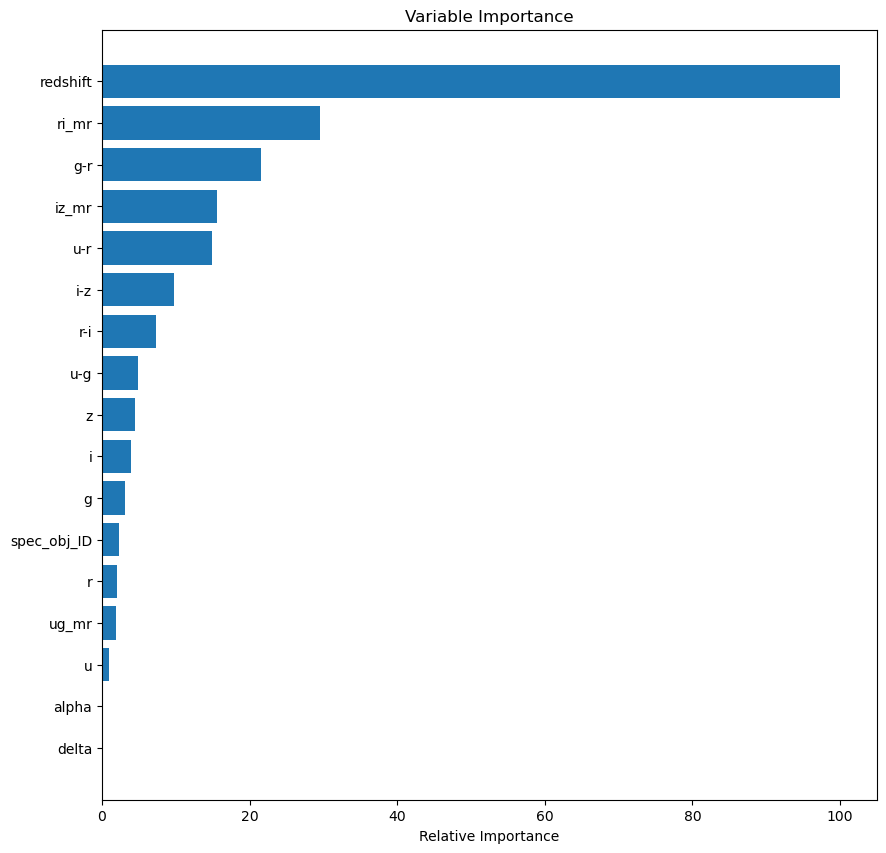

In [37]:
# train random forest classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
clf.fit(X_, y)

# get feature importances from the model
feature_importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(feature_importances)[::-1]

plot_feature_importance(clf, X_, imp_cols_)

### 1.2. Gini

Feature ranking:
1. Feature redshift (0.8612324567783006)
2. Feature g-r (0.04893648780797639)
3. Feature r (0.016018636255978227)
4. Feature g (0.014996635345875982)
5. Feature spec_obj_ID (0.008102525827136584)
6. Feature ri_mr (0.005931104858314401)
7. Feature r-i (0.005594791796970767)
8. Feature delta (0.005272362236909414)
9. Feature alpha (0.005222473449543572)
10. Feature u-r (0.005054991177883808)
11. Feature i-z (0.004061979839340625)
12. Feature ug_mr (0.004018343859733465)
13. Feature z (0.0033590907444038644)
14. Feature iz_mr (0.0032363519668740723)
15. Feature u (0.0031816498822822338)
16. Feature i (0.002944511625198775)
17. Feature u-g (0.002835606547277209)


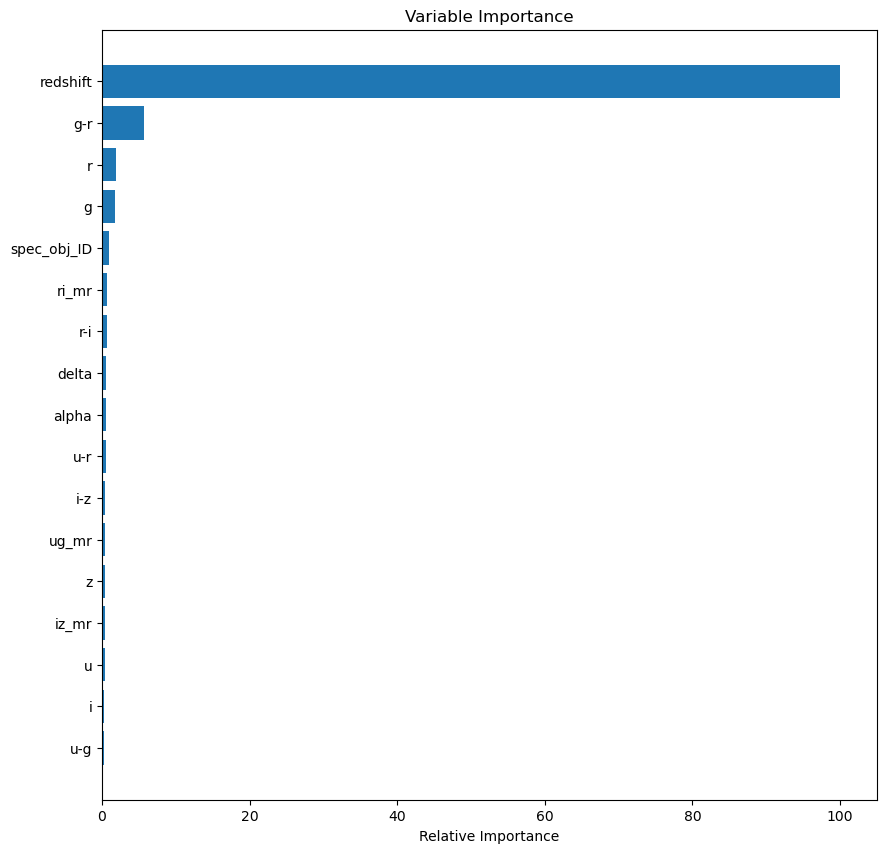

In [38]:
# train gini
clf = DecisionTreeClassifier(criterion='gini', random_state=42)
clf.fit(X_, y)

# get feature importances from the model
feature_importances = clf.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plot_feature_importance(clf, X_, imp_cols_)

Według modelu Gini, cechami posiadającymi współczynnik ważności >= 5% są:
- redshift,
- g-r.  

A co jeśli nie będzie redshift?
### 1.2.1. Gini, ale bez zmiennej redshift CZY TO MA SENS???

Feature ranking:
1. Feature ri_mr (0.37236332536064853)
2. Feature u-r (0.12671728248729583)
3. Feature spec_obj_ID (0.091552878868322)
4. Feature g-r (0.06897341149708859)
5. Feature iz_mr (0.041706013500446164)
6. Feature i (0.04077035175681329)
7. Feature r-i (0.03433591720991815)
8. Feature g (0.033835375255755445)
9. Feature u-g (0.03365807691580666)
10. Feature delta (0.0272208278678906)
11. Feature alpha (0.02679974007317369)
12. Feature i-z (0.02435113416785393)
13. Feature z (0.02384633309606243)
14. Feature ug_mr (0.02215895323695766)
15. Feature u (0.0186145832976263)
16. Feature r (0.013095795408340813)


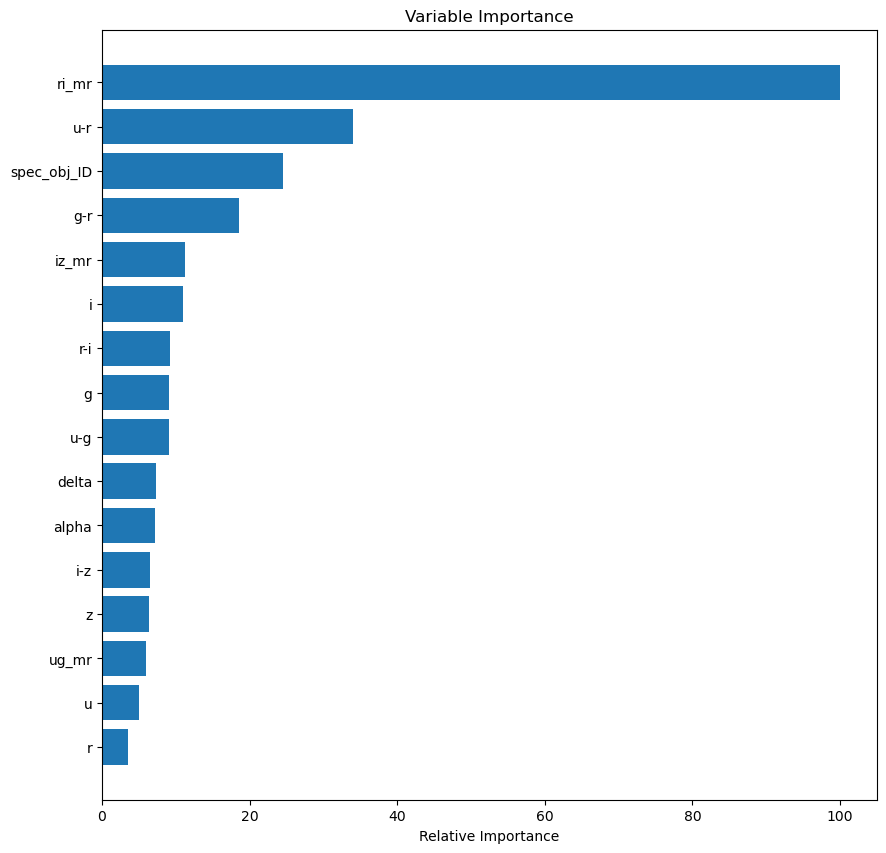

In [39]:
# for testing purposes remove redshift from X_
X_no_redshift = X_.drop(columns=['redshift'])
imp_cols_no_redshift = imp_cols_.copy()
imp_cols_no_redshift.remove('redshift')

# train gini
clf = DecisionTreeClassifier(criterion='gini', random_state=42)
clf.fit(X_no_redshift, y)

# get feature importances from the model
feature_importances = clf.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plot_feature_importance(clf, X_no_redshift, imp_cols_no_redshift)

Teraz, zmienne:
- ri_mr (poprzednio bardzo nisko),
- u-r,
- spec_obj_ID,
- g-r

mają współczynniki Gini >= 5%.

### 1.3. Tylko cechy podstawowe


Random Forest
Feature ranking:
1. Feature redshift (0.6645266697666726)
2. Feature z (0.0970077542729927)
3. Feature g (0.06262542492272948)
4. Feature i (0.062055616537353614)
5. Feature u (0.05567218816556348)
6. Feature spec_obj_ID (0.034465435527367236)
7. Feature r (0.021729454403647392)
8. Feature delta (0.001143460018788334)
9. Feature alpha (0.0007739963848850891)


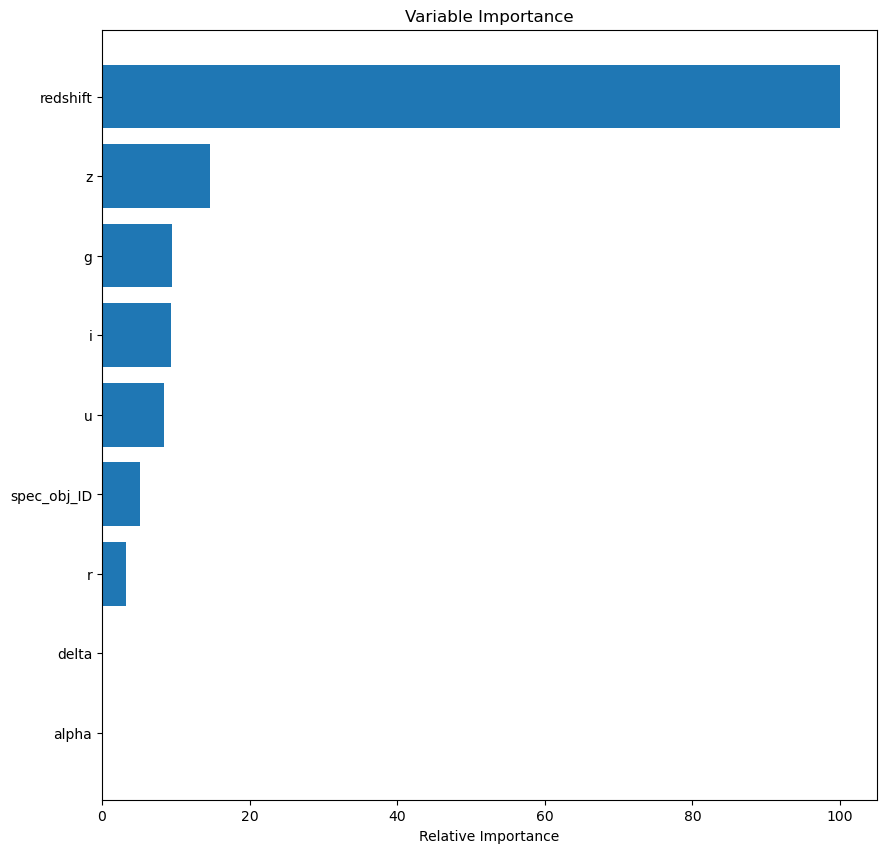

Gini Decision Tree
Feature ranking:
1. Feature redshift (0.8655909945368427)
2. Feature g (0.053704502614879225)
3. Feature u (0.025491094607656778)
4. Feature z (0.011691287518352965)
5. Feature i (0.010669138135211757)
6. Feature spec_obj_ID (0.009915345905802914)
7. Feature r (0.00865389374950727)
8. Feature alpha (0.007479638692331414)
9. Feature delta (0.006804104239414939)


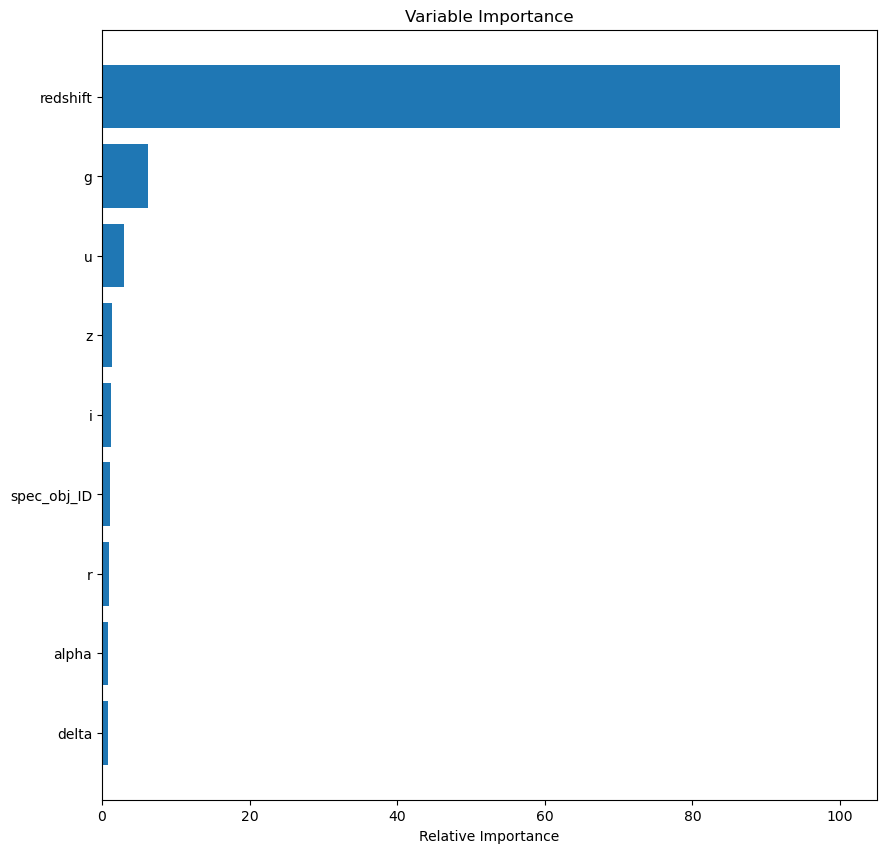

In [40]:
# train random forest classifier
print("Random Forest")
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
clf.fit(X, y)

# get feature importances from the model
feature_importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(feature_importances)[::-1]

plot_feature_importance(clf, X, imp_cols)

# train gini
print("Gini Decision Tree")
clf = DecisionTreeClassifier(criterion='gini', random_state=42)
clf.fit(X, y)

# get feature importances from the model
feature_importances = clf.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plot_feature_importance(clf, X, imp_cols)

### 1.4. Wybór cech do modelu

Według **random forest classifier** najmniej istotnymi cechami były:
- u-g 
- z 
- i 
- g 
- spec_obj_ID 
- r 
- ug_mr 
- u 
- alpha 
- delta 

Według **gini (decision tree)** najmniej istotnymi cechami były:
- r
- r-i 
- alpha 
- ri_mr 
- delta 
- u-r 
- i-z 
- u-g 
- z 
- iz_mr 
- ug_mr 
- i 
- u 

Zatem w modelu nie będziemy uwzględniać:
- u
- alpha (choć mapa nieba inaczej sugerowała)
- delta (choć mapa nieba inaczej sugerowała)
- r (pomimo 3. pozycji w Gini (0.02 pkt))
- ug_mr
- u-g

Usuwamy powyższe z imp_cols_. Zachowamy ramki danych treningową i testową bez nowych cech pod zmiennymi X_org i X_test_org. Do ramek X i X_test dodajemy nowe cechy.

In [41]:
# let X_org be the original X and X_test_org be the original X_test
X_org = X.copy()
X_test_org = X_test.copy()

# let X be the X_ with removed columns
X = X_.drop(columns=['u', 'alpha', 'delta', 'r', 'ug_mr', 'u-g'])


# add 'g-r', 'r-i', 'i-z', 'u-r', 'ri_mr', 'iz_mr' to X_test 
X_test['g-r'] = X_test['g'] - X_test['r']
X_test['r-i'] = X_test['r'] - X_test['i']
X_test['i-z'] = X_test['i'] - X_test['z']
X_test['u-r'] = X_test['u'] - X_test['r']
X_test['ri_mr'] = np.log(X_test['r'] / X_test['i'])
X_test['iz_mr'] = np.log(X_test['i'] / X_test['z'])

# change NaNs to median value --- there is only one NaN in each column
median_r_i = X_test['ri_mr'].median()
X_test['ri_mr'] = X_test['ri_mr'].fillna(median_r_i)
median_iz_mr = X_test['iz_mr'].median()
X_test['iz_mr'] = X_test['iz_mr'].fillna(median_iz_mr)

X_test = X_test.drop(columns=['u', 'alpha', 'delta', 'r'])


Od teraz ramki danych są uzupełnione o stworzone i wybrane cechy.

## 3. Strojenie parametrów i przygotowanie cross-walidacji
Modele będziemy badać na wszystkim dostępnym zespołowi budowy danych - treningowych oraz na testowych. Ostatecznie wybierzemy najlepszy.  
Accuracy score będzie to uśredniony wynik dla dwóch zestawów danych (wagą będzie liczba rekordów w zestawie danych).  
Macierze wyświetlane są dla danych *testowych*, natomiast wyniki - dla obu.

W modelach badaliśmy różne parametry i wybraliśmy te o paramatrach z największą dokłądnością.

### 3.1. Strojenie parametrów
Wykorzystujemy RandomizedSearchCV do poszukiwania najlepszych parametrów dla naszych modeli.

In [42]:
def tune_hyperparameters(estimator, param_grid, X, y, cv=5, random_state=42, n_iter=10):
    """
    Perform hyperparameter tuning for the given estimator using either Grid Search or Random Search.

    Parameters:
    - estimator: The estimator (e.g., classifier or regressor) for which hyperparameters are to be tuned.
    - param_grid: Dictionary specifying the hyperparameter grid for Grid Search or the parameter distribution for Random Search.
    - X: Input features.
    - y: Target variable.
    - cv: Number of cross-validation folds. Default is 5.
    - n_iter: Number of parameter settings that are sampled. Only used for Random Search. Default is None.
    - random_state: Seed for random number generator. Only used for Random Search. Default is None.

    Returns:
    - best_params: Best hyperparameters found during tuning.
    - best_score: Best cross-validation score achieved.
    """
    
    tuner = RandomizedSearchCV(estimator, param_grid, n_iter=n_iter, cv=cv, random_state=random_state)
    
    tuner.fit(X, y)

    best_params = tuner.best_params_
    best_score = tuner.best_score_

    return best_params, best_score

### 3.2. Confusion matrix

In [43]:
def plot_heatmap(matrix, title, labels):
    """
    This function plots the heatmap.
    
    Parameters
    ----------
    `matrix`: 2D array
    `title`: title
    `labels`: target values
    
    Returns none.
    """
    sns.heatmap(data=matrix, annot=True, fmt='.2f', linewidths=0.1,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel(xlabel='Predicted Class')
    plt.ylabel(ylabel='Actual Class')
    plt.title(label=title, fontsize=10)

def plot_confusion_matrix(y_true, y_pred, labels):
    """
    This function plots:
        1. Confusion matrix
        2. Precision matrix
        3. Recall matrix
    
    Parameters
    ----------
    `y_true`: ground truth (or actual) values
    `y_pred`: predicted values
    `labels`: target values
    
    Returns none.
    """
    cmat = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels)
    pmat = cmat / cmat.sum(axis=0)
    print("Column sum of precision matrix: {}".format(pmat.sum(axis=0)))
    rmat = ((cmat.T) / (cmat.sum(axis=1).T)).T
    print("Row sum of recall matrix:       {}".format(rmat.sum(axis=1)))
    
    plt.figure(figsize=(15, 3))
    plt.subplot(131)
    plot_heatmap(matrix=cmat, title='Confusion Matrix', labels=labels)
    plt.subplot(132)
    plot_heatmap(matrix=pmat, title='Precision Matrix', labels=labels)
    plt.subplot(133)
    plot_heatmap(matrix=rmat, title='Recall Matrix', labels=labels)
    plt.show()    

def plot_roc_curve(y_true, y_prob, class_label, ax):
    """
    This function plots the ROC curve.
    
    Parameters
    ----------
    `y_true`: ground truth (or actual) values
    `y_prob`: predicted probabilities
    'class_label': class label 
    `ax`: axis object to plot the ROC curve on
    
    Returns none.
    """
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='#1f77b4', linestyle='-', label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color = 'orange', linestyle = '--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic ({})'.format(class_label))
    ax.legend(loc="lower right")

### 3.3. Cross-walidacja
Wykorzystamy funkcję do znajdowania najlepszych parametrów.

In [44]:
def train_and_evaluate_model(estimator, param_grid, X_train, y_train, X_test, y_test, cv=5):
    """
    Train the model, tune hyperparameters, and evaluate performance.

    Parameters:
    - estimator: The estimator (e.g., classifier or regressor) to be trained.
    - param_grid: Dictionary specifying the hyperparameter grid for Grid Search or the parameter distribution for Random Search.
    - X_train: Training features.
    - y_train: Training target variable.
    - X_test: Testing features.
    - y_test: Testing target variable.

    Returns:
    - best_params: Best hyperparameters found during tuning.
    - train_accuracy: Accuracy of the model on the training dataset.
    - test_accuracy: Accuracy of the model on the testing dataset.
    - cv_scores: Cross-validation scores.
    """
    # Hyperparameter tuning
    best_params, _ = tune_hyperparameters(estimator, param_grid, X_train, y_train)
    
    # Fit the best model to the training data
    best_model = estimator.set_params(**best_params)
    best_model.fit(X_train, y_train)
    
    # Predictions
    train_preds = best_model.predict(X_train)
    test_preds = best_model.predict(X_test)
    
    # Calculate accuracy
    train_accuracy = accuracy_score(y_train, train_preds)
    test_accuracy = accuracy_score(y_test, test_preds)
    
    # Cross-validation
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv)
    cv_test_scores = cross_val_score(best_model, X_test, y_test, cv=cv)

    # print best params 
    print("Best hyperparameters: ", best_params)
    print("---------------------------------------------------------------------------------")
    # Report for train
    print("TRAIN")
    print("Accuracy: ", train_accuracy)
    plot_confusion_matrix(y_train, train_preds, labels=['GALAXY', 'QSO', 'STAR'])
    print(classification_report(y_train, train_preds, target_names=['GALAXY', 'QSO', 'STAR']))
    print("---------------------------------------------------------------------------------")

    # Report for test
    print("TEST")
    print("Accuracy: ", test_accuracy)
    plot_confusion_matrix(y_test, test_preds, labels=['GALAXY', 'QSO', 'STAR'])
    print(classification_report(y_test, test_preds, target_names=['GALAXY', 'QSO', 'STAR']))
    print("---------------------------------------------------------------------------------")

    # Cross-validation scores
    print("Cross-validation scores: ", cv_scores)
    print("Mean CV score: ", np.mean(cv_scores))    
    print("---------------------------------------------------------------------------------")
    print("Cross-validation scores for test data: ", cv_test_scores)
    print("Mean CV score for test data: ", np.mean(cv_test_scores))

    # Plot ROC curve for each class and calculate AUC
    print("---------------------------------------------------------------------------------")
    print("ROC curve and AUC for each class")
    _, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i, ax in enumerate(axs):
        y_true_binary = (y_test == best_model.classes_[i]).astype(int)
        y_prob = best_model.predict_proba(X_test)[:, i]
        plot_roc_curve(y_true_binary, y_prob, class_label=best_model.classes_[i], ax=ax)
    
    plt.tight_layout()
    plt.show()
    
    return best_params, train_accuracy, test_accuracy, cv_scores, cv_test_scores

## 4. Modelowanie
Przeanalizujemy modele:
1. Regresja logistyczna
2. Random forest
3. Naive Bayes
4. K Neighbours
5. Drzewa decyzyjne 
6. Ada boost
7. SVC
8. XGBoost
9. Stacking

### 4.1. Regresja logistyczna

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:976: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.59310204 0.95610204        nan 0.92265306
 0.59461224        nan        nan 0.7342449 ]
  warnings.warn(


Best hyperparameters:  {'penalty': 'l2', 'C': 100}
---------------------------------------------------------------------------------
TRAIN
Accuracy:  0.9566326530612245
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


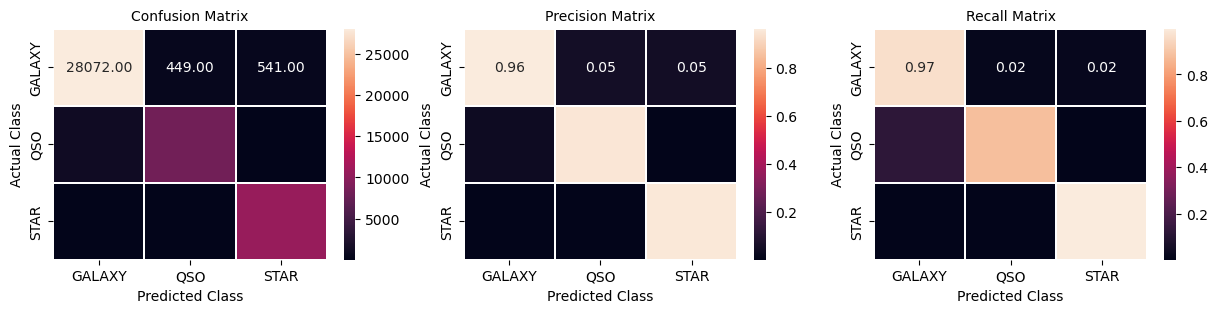

              precision    recall  f1-score   support

      GALAXY       0.96      0.97      0.96     29062
         QSO       0.95      0.88      0.91      9288
        STAR       0.95      1.00      0.97     10650

    accuracy                           0.96     49000
   macro avg       0.95      0.95      0.95     49000
weighted avg       0.96      0.96      0.96     49000

---------------------------------------------------------------------------------
TEST
Accuracy:  0.9544285714285714
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


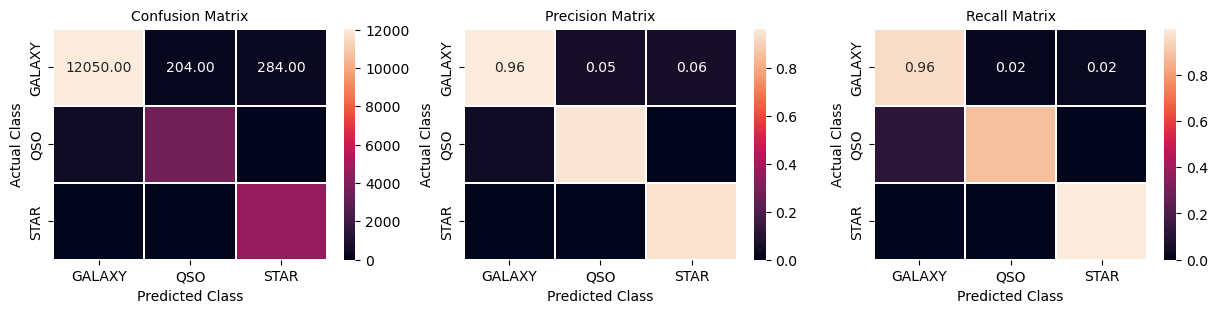

              precision    recall  f1-score   support

      GALAXY       0.96      0.96      0.96     12538
         QSO       0.95      0.88      0.91      3973
        STAR       0.94      1.00      0.97      4489

    accuracy                           0.95     21000
   macro avg       0.95      0.95      0.95     21000
weighted avg       0.95      0.95      0.95     21000

---------------------------------------------------------------------------------
Cross-validation scores:  [0.95612245 0.95571429 0.95581633 0.9544898  0.95836735]
Mean CV score:  0.9561020408163265
---------------------------------------------------------------------------------
Cross-validation scores for test data:  [0.95190476 0.95047619 0.95285714 0.9502381  0.95214286]
Mean CV score for test data:  0.9515238095238094
---------------------------------------------------------------------------------
ROC curve and AUC for each class


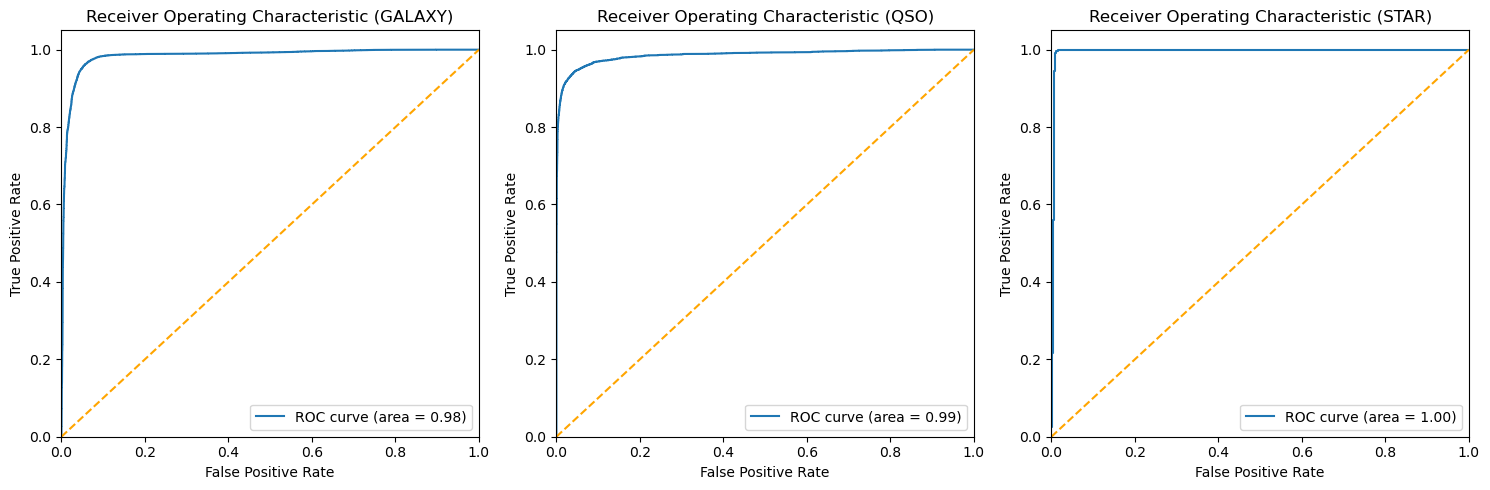

In [45]:
# logistic regression
lg = LogisticRegression(max_iter=1000)
dist = dict(C=[10 ** x for x in range(-4, 3)], penalty=['l2', 'l1'])
lg_best_params, lg_train_accuracy, lg_test_accuracy, lg_cv_scores, lg_cv_test_scores = train_and_evaluate_model(lg, param_grid=dist, X_train=X, y_train=y, X_test=X_test, y_test=y_test)

### SHAP

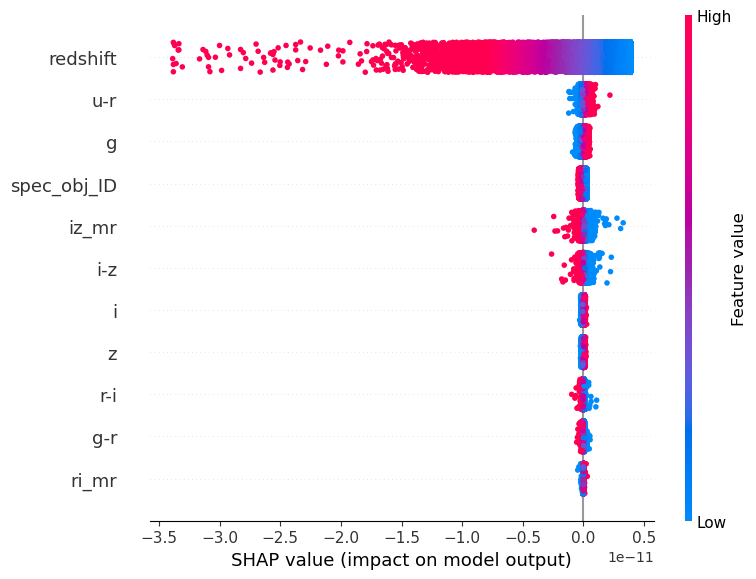

In [46]:
# SHAP value
explainer = shap.LinearExplainer(lg, X)
shap_values = explainer.shap_values(X_test)

# Sum up the SHAP values for all classes
shap_values_sum = shap_values.sum(axis=2)

# Generate SHAP plot
shap.summary_plot(shap_values_sum, X_test, feature_names=X.columns, max_display=X_test.shape[1])


In [70]:
shap.initjs()
# Generate force plot for the first observation and the first class ('GALAXY')
print("GALAXY")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,0], X_test.iloc[0,:], feature_names=X.columns)

GALAXY


In [48]:

# Generate force plot for the first observation and the second class ('QSO')
print("QSO")
shap.force_plot(explainer.expected_value[1], shap_values[0,:,1], X_test.iloc[0,:], feature_names=X.columns)

QSO


In [49]:
# Generate force plot for the first observation and the third class ('STAR')
print("STAR")
shap.force_plot(explainer.expected_value[2], shap_values[0,:,2], X_test.iloc[0,:], feature_names=X.columns)

STAR


### 4.2. Random forest 

Best hyperparameters:  {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 25, 'criterion': 'log_loss'}
---------------------------------------------------------------------------------
TRAIN
Accuracy:  0.9987755102040816
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


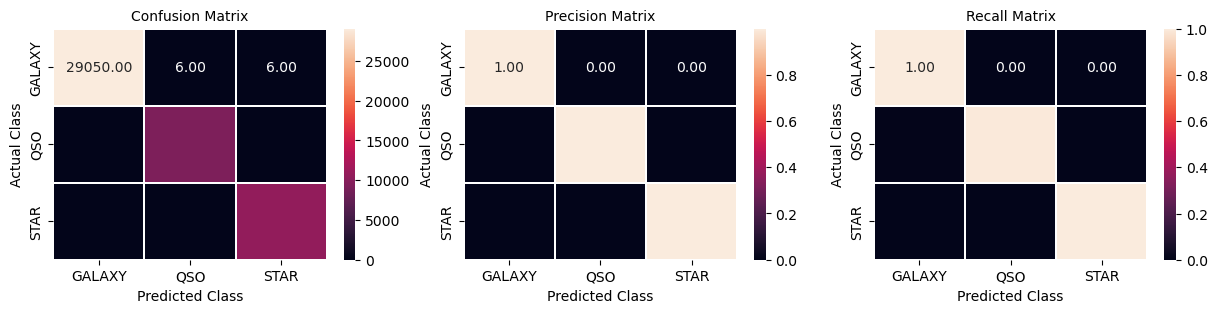

              precision    recall  f1-score   support

      GALAXY       1.00      1.00      1.00     29062
         QSO       1.00      0.99      1.00      9288
        STAR       1.00      1.00      1.00     10650

    accuracy                           1.00     49000
   macro avg       1.00      1.00      1.00     49000
weighted avg       1.00      1.00      1.00     49000

---------------------------------------------------------------------------------
TEST
Accuracy:  0.9788095238095238
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


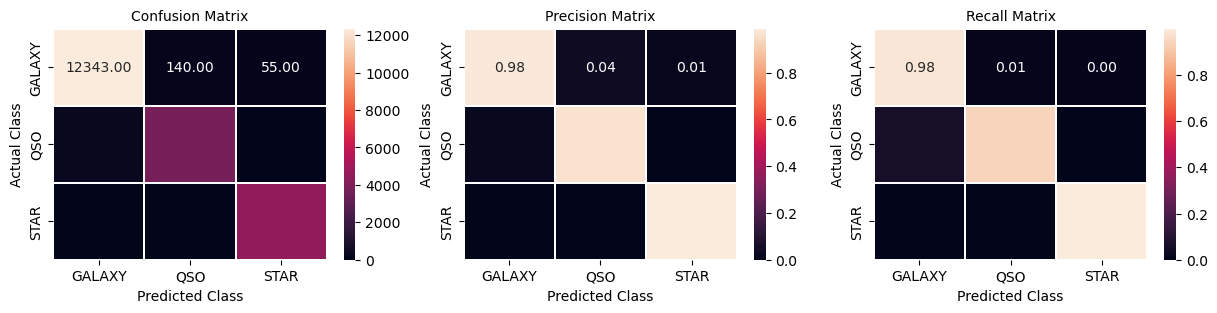

              precision    recall  f1-score   support

      GALAXY       0.98      0.98      0.98     12538
         QSO       0.96      0.94      0.95      3973
        STAR       0.99      1.00      0.99      4489

    accuracy                           0.98     21000
   macro avg       0.98      0.97      0.98     21000
weighted avg       0.98      0.98      0.98     21000

---------------------------------------------------------------------------------
Cross-validation scores:  [0.97744898 0.97714286 0.9794898  0.97887755 0.97744898]
Mean CV score:  0.9780816326530613
---------------------------------------------------------------------------------
Cross-validation scores for test data:  [0.97904762 0.97547619 0.97928571 0.97571429 0.97666667]
Mean CV score for test data:  0.9772380952380952
---------------------------------------------------------------------------------
ROC curve and AUC for each class


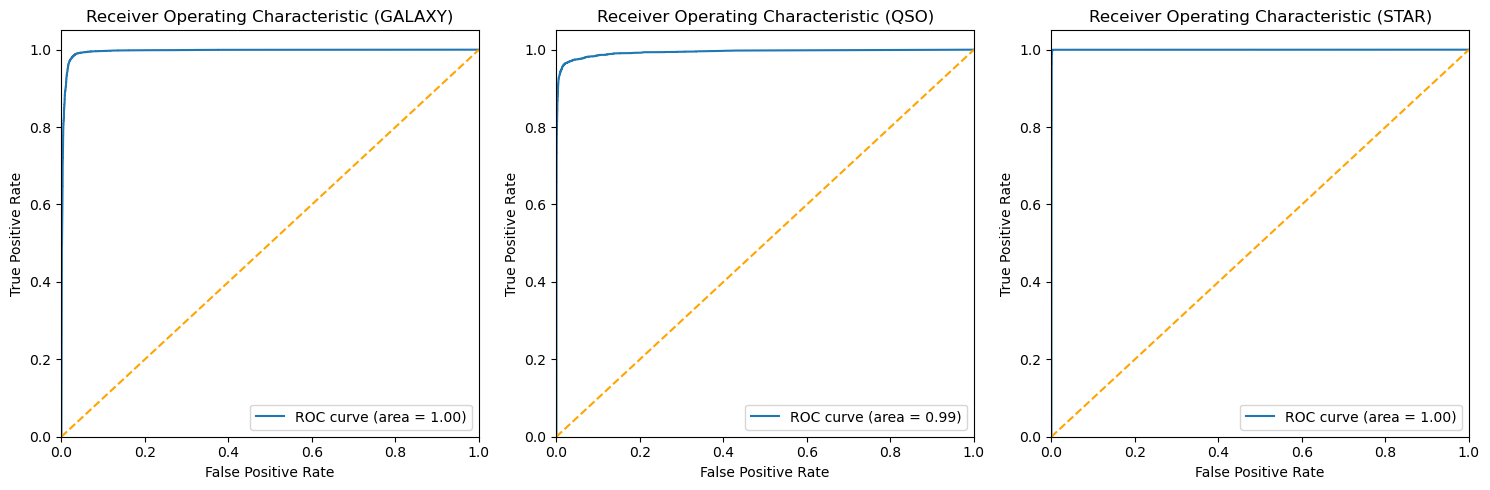

In [50]:
# random forest
rf = RandomForestClassifier(random_state=42)
dist = dict(n_estimators=[5, 10, 25, 50, 100, 200, 250, 500, 1000],
            criterion=['gini', 'entropy', 'log_loss'],
            max_depth=[1, 5, 10, 25, 50, 100, 150],
            min_samples_split=[1, 5, 10, 25, 50, 100, 250, 500])
rf_best_params, rf_train_accuracy, rf_test_accuracy, rf_cv_scores, rf_cv_test_scores = train_and_evaluate_model(rf, param_grid=dist, X_train=X, y_train=y, X_test=X_test, y_test=y_test)

### SHAP

In [51]:
# SHAP value
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

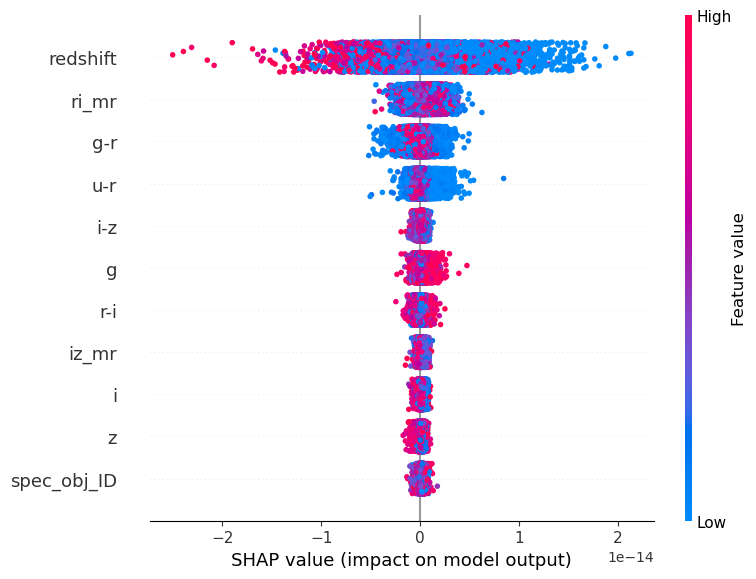

In [52]:
# Sum up the SHAP values for all classes
shap_values_sum = shap_values.sum(axis=2)

# Generowanie wykresu podsumowującego wpływ cech na predykcje modelu
shap.summary_plot(shap_values_sum, X_test)

In [53]:
# Generate force plot for the first observation and the first class ('GALAXY')
print("GALAXY")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,0], X_test.iloc[0,:], feature_names=X.columns)

GALAXY


In [54]:
# Generate force plot for the first observation and the first class ('QSO')
print("QSO")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,1], X_test.iloc[0,:], feature_names=X.columns)

QSO


In [55]:
# Generate force plot for the first observation and the first class ('STAR')
print("STAR")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,2], X_test.iloc[0,:], feature_names=X.columns)

STAR


### 4.3. Naive Bayes

Best hyperparameters:  {'var_smoothing': 5.336699231206302e-08}
---------------------------------------------------------------------------------
TRAIN
Accuracy:  0.9273469387755102
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


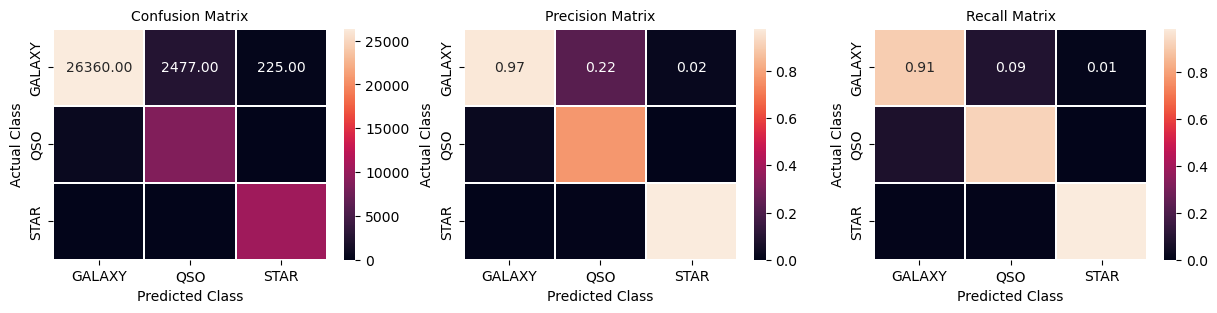

              precision    recall  f1-score   support

      GALAXY       0.97      0.91      0.94     29062
         QSO       0.77      0.92      0.84      9288
        STAR       0.98      0.99      0.98     10650

    accuracy                           0.93     49000
   macro avg       0.91      0.94      0.92     49000
weighted avg       0.93      0.93      0.93     49000

---------------------------------------------------------------------------------
TEST
Accuracy:  0.9263333333333333
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


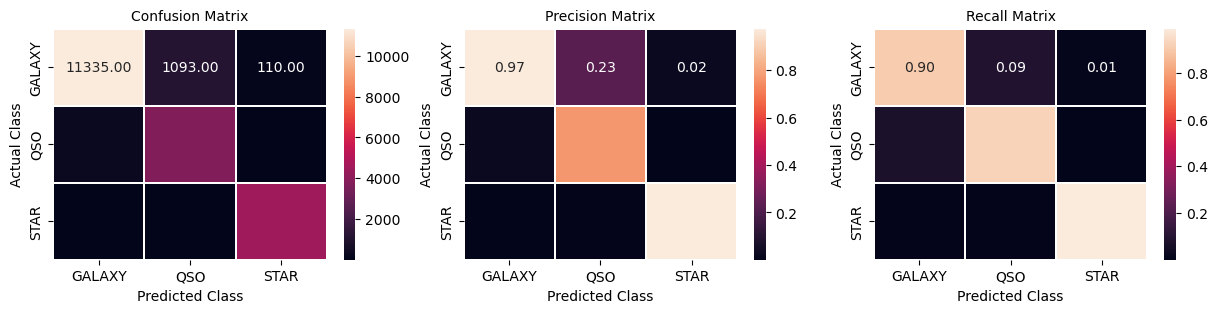

              precision    recall  f1-score   support

      GALAXY       0.97      0.90      0.94     12538
         QSO       0.77      0.93      0.84      3973
        STAR       0.98      0.99      0.98      4489

    accuracy                           0.93     21000
   macro avg       0.90      0.94      0.92     21000
weighted avg       0.93      0.93      0.93     21000

---------------------------------------------------------------------------------
Cross-validation scores:  [0.9277551  0.92683673 0.92346939 0.92857143 0.92969388]
Mean CV score:  0.9272653061224491
---------------------------------------------------------------------------------
Cross-validation scores for test data:  [0.92761905 0.91666667 0.93095238 0.92928571 0.92285714]
Mean CV score for test data:  0.9254761904761905
---------------------------------------------------------------------------------
ROC curve and AUC for each class


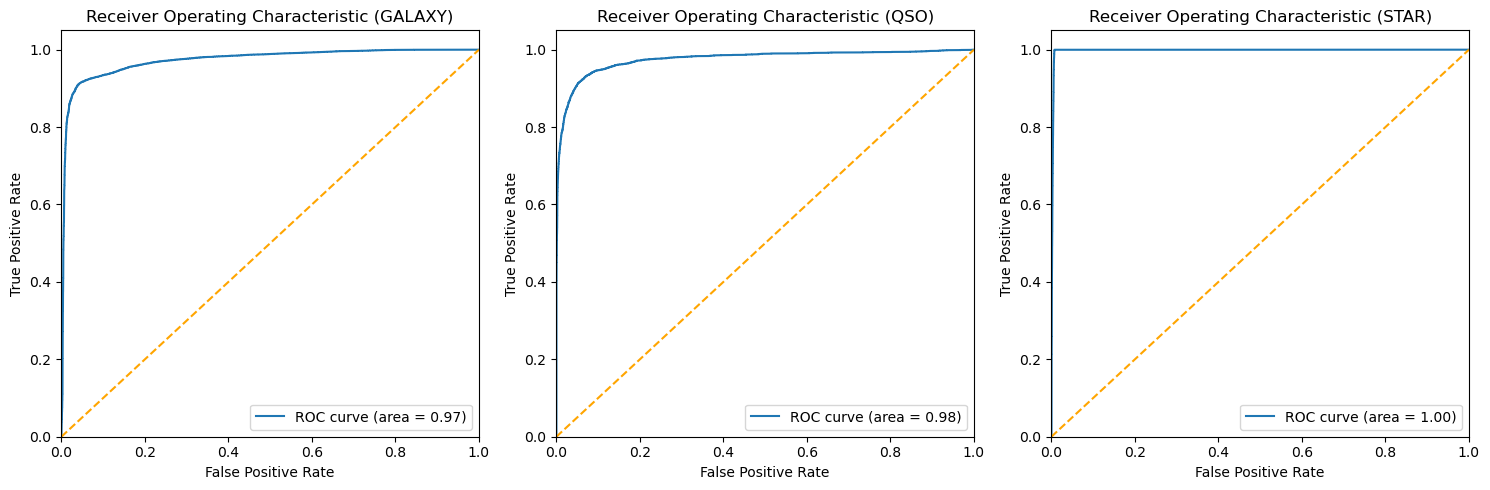

In [56]:
nb = GaussianNB()
dist = {'var_smoothing': np.logspace(0,-9, num=100)}
nb_best_params, nb_train_accuracy, nb_test_accuracy, nb_cv_scores, nb_cv_test_scores = train_and_evaluate_model(nb, param_grid=dist, X_train=X, y_train=y, X_test=X_test, y_test=y_test)

### SHAP

In [57]:
# Generate background samples based on training data
background = shap.sample(X, 20)

# Create SHAP explainer for GaussianNB model
explainer = shap.KernelExplainer(nb.predict_proba, background)

# SHAP values for GaussianNB model
shap_values = explainer.shap_values(X_test)

  0%|          | 0/21000 [00:00<?, ?it/s]

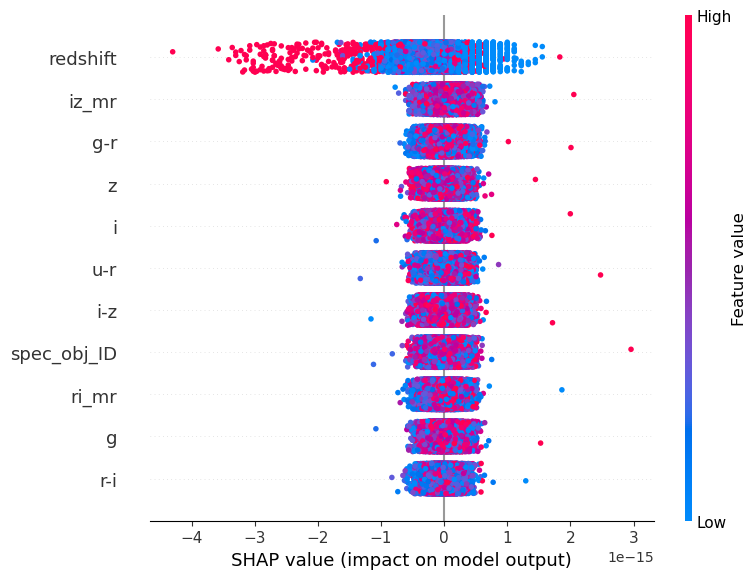

In [58]:
# Sum up the SHAP values for all classes
shap_values_sum = shap_values.sum(axis=2)

# Generowanie wykresu podsumowującego wpływ cech na predykcje modelu
shap.summary_plot(shap_values_sum, X_test)

In [59]:
# Generate force plot for the first observation and the first class ('GALAXY')
print("GALAXY")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,0], X_test.iloc[0,:], feature_names=X.columns)

GALAXY


In [60]:
# Generate force plot for the first observation and the first class ('QSO')
print("")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,1], X_test.iloc[0,:], feature_names=X.columns)

In [61]:
# Generate force plot for the first observation and the first class ('STAR')
print("STAR")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,2], X_test.iloc[0,:], feature_names=X.columns)

STAR


### 4.4. K Neighbours

Best hyperparameters:  {'n_neighbors': 5}
---------------------------------------------------------------------------------
TRAIN
Accuracy:  0.965204081632653
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


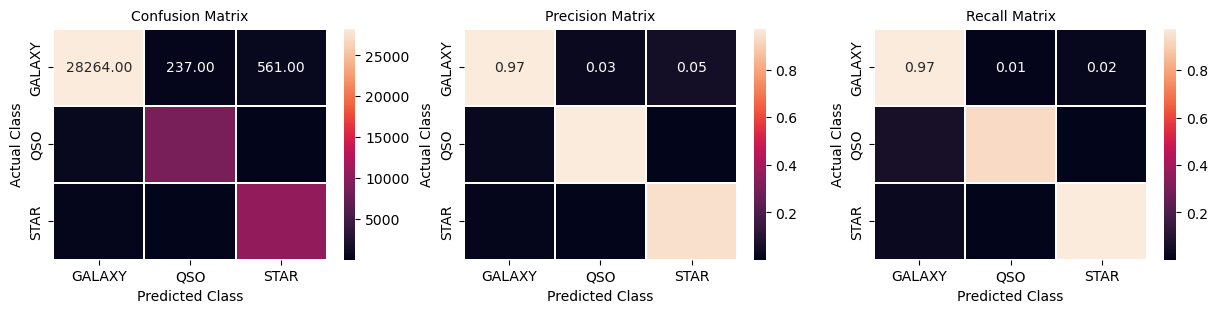

              precision    recall  f1-score   support

      GALAXY       0.97      0.97      0.97     29062
         QSO       0.97      0.93      0.95      9288
        STAR       0.95      0.97      0.96     10650

    accuracy                           0.97     49000
   macro avg       0.96      0.96      0.96     49000
weighted avg       0.97      0.97      0.97     49000

---------------------------------------------------------------------------------
TEST
Accuracy:  0.954952380952381
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


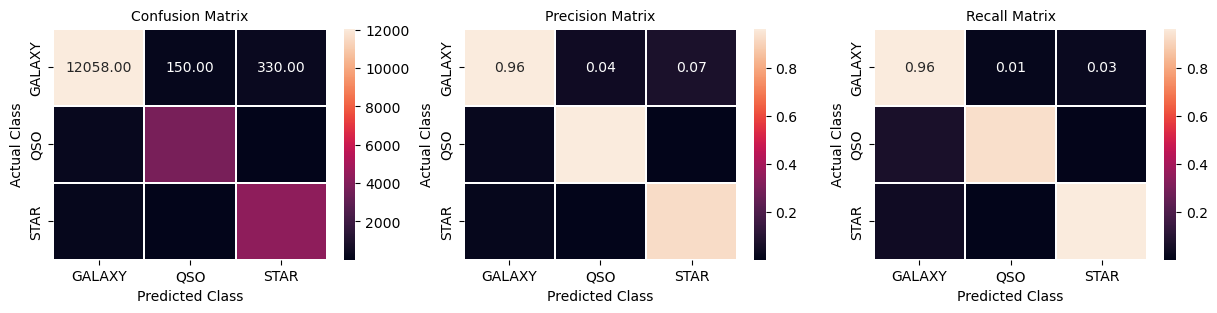

              precision    recall  f1-score   support

      GALAXY       0.96      0.96      0.96     12538
         QSO       0.96      0.93      0.94      3973
        STAR       0.93      0.96      0.94      4489

    accuracy                           0.95     21000
   macro avg       0.95      0.95      0.95     21000
weighted avg       0.96      0.95      0.95     21000

---------------------------------------------------------------------------------
Cross-validation scores:  [0.95653061 0.95132653 0.95479592 0.95357143 0.95285714]
Mean CV score:  0.9538163265306123
---------------------------------------------------------------------------------
Cross-validation scores for test data:  [0.94571429 0.94380952 0.9447619  0.94880952 0.94214286]
Mean CV score for test data:  0.9450476190476191
---------------------------------------------------------------------------------
ROC curve and AUC for each class


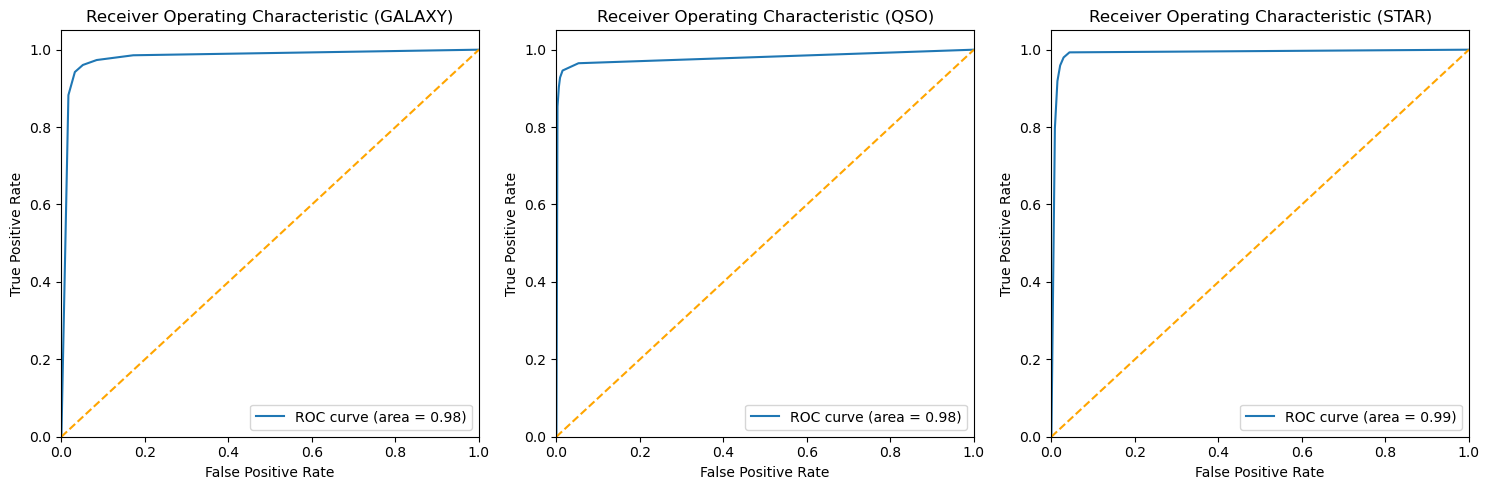

In [62]:
knn = KNeighborsClassifier()
dist = {'n_neighbors': [3, 5, 9, 15, 21, 31, 41, 51, 71, 99]}
knn_best_params, knn_train_accuracy, knn_test_accuracy, knn_cv_scores, knn_cv_test_scores = train_and_evaluate_model(knn, param_grid=dist, X_train=X, y_train=y, X_test=X_test, y_test=y_test)

### SHAP

In [20]:
# Generate background samples based on training data
background = shap.kmeans(X, 1)

# Create the KernelExplainer
explainer = shap.KernelExplainer(knn.predict_proba, background)

# Calculate shap_values
shap_values = explainer.shap_values(X_test)

  0%|          | 0/21000 [00:00<?, ?it/s]

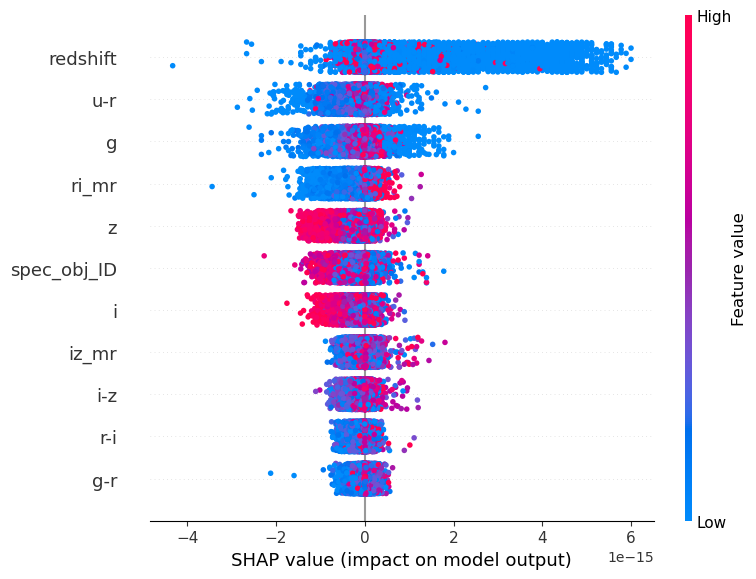

In [21]:
# Sum up the SHAP values for all classes
shap_values_sum = shap_values.sum(axis=2)

# Generowanie wykresu podsumowującego wpływ cech na predykcje modelu
shap.summary_plot(shap_values_sum, X_test)

In [22]:
# Generate force plot for the first observation and the first class ('GALAXY')
print("GALAXY")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,0], X_test.iloc[0,:], feature_names=X.columns)

GALAXY


In [23]:
# Generate force plot for the first observation and the first class ('QSO')
print("QSO")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,1], X_test.iloc[0,:], feature_names=X.columns)

QSO


In [24]:
# Generate force plot for the first observation and the first class ('STAR')
print("STAR")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,2], X_test.iloc[0,:], feature_names=X.columns)

STAR


### 4.5. Drzewa decyzyjne

Best hyperparameters:  {'min_samples_split': 5, 'max_depth': 10, 'criterion': 'entropy'}
---------------------------------------------------------------------------------
TRAIN
Accuracy:  0.9821020408163266
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


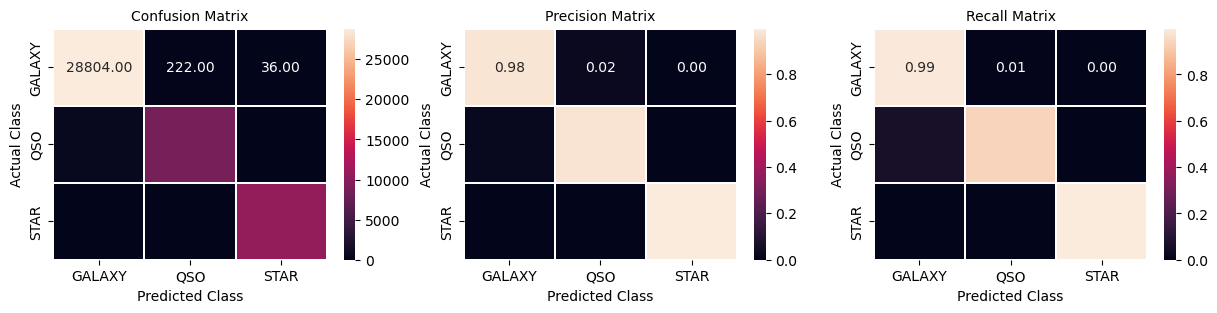

              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.99     29062
         QSO       0.98      0.94      0.96      9288
        STAR       1.00      1.00      1.00     10650

    accuracy                           0.98     49000
   macro avg       0.98      0.97      0.98     49000
weighted avg       0.98      0.98      0.98     49000

---------------------------------------------------------------------------------
TEST
Accuracy:  0.9724761904761905
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


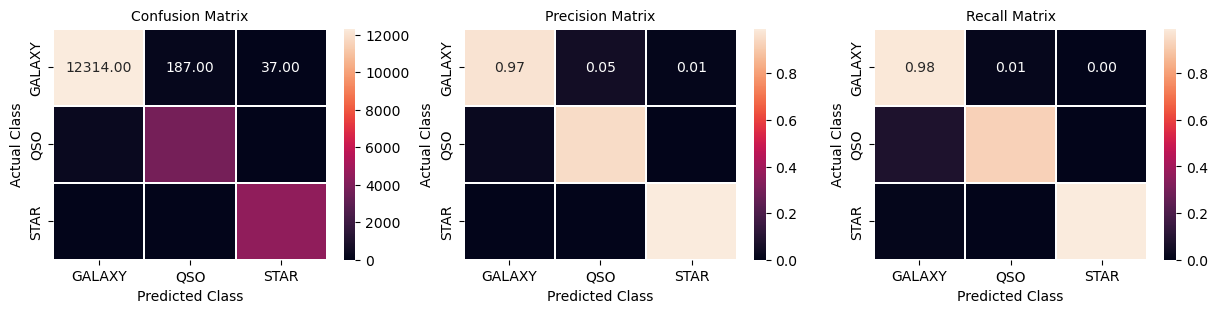

              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.98     12538
         QSO       0.95      0.92      0.94      3973
        STAR       0.99      0.99      0.99      4489

    accuracy                           0.97     21000
   macro avg       0.97      0.96      0.97     21000
weighted avg       0.97      0.97      0.97     21000

---------------------------------------------------------------------------------
Cross-validation scores:  [0.97418367 0.97091837 0.97346939 0.97091837 0.97316327]
Mean CV score:  0.972530612244898
---------------------------------------------------------------------------------
Cross-validation scores for test data:  [0.97119048 0.96333333 0.96880952 0.97095238 0.96452381]
Mean CV score for test data:  0.9677619047619046
---------------------------------------------------------------------------------
ROC curve and AUC for each class


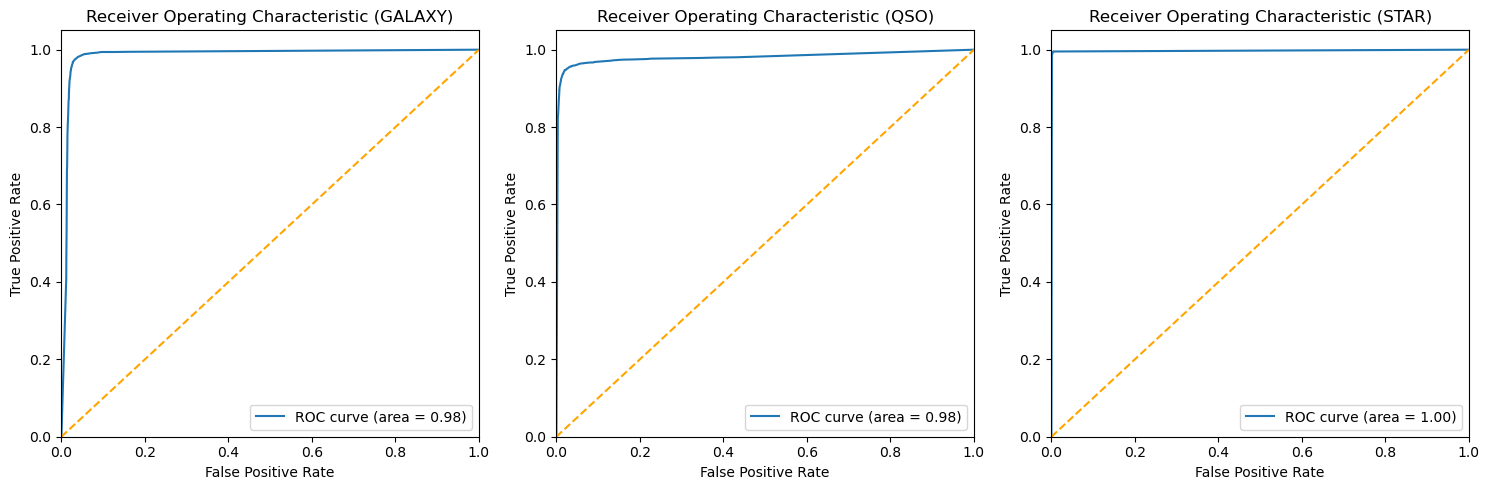

In [63]:
dt = DecisionTreeClassifier()
dist  = dict(criterion=['gini', 'entropy', 'log_loss'],
            max_depth=[1, 5, 10, 50, 75, 100],
            min_samples_split=[5, 10, 100, 250, 500])
dt_best_params, dt_train_accuracy, dt_test_accuracy, dt_cv_scores, dt_cv_test_scores = train_and_evaluate_model(dt, param_grid=dist, X_train=X, y_train=y, X_test=X_test, y_test=y_test)     

### SHAP

In [64]:
# Create the TreeExplainer
explainer = shap.TreeExplainer(dt)

# Calculate shap_values
shap_values = explainer.shap_values(X_test)

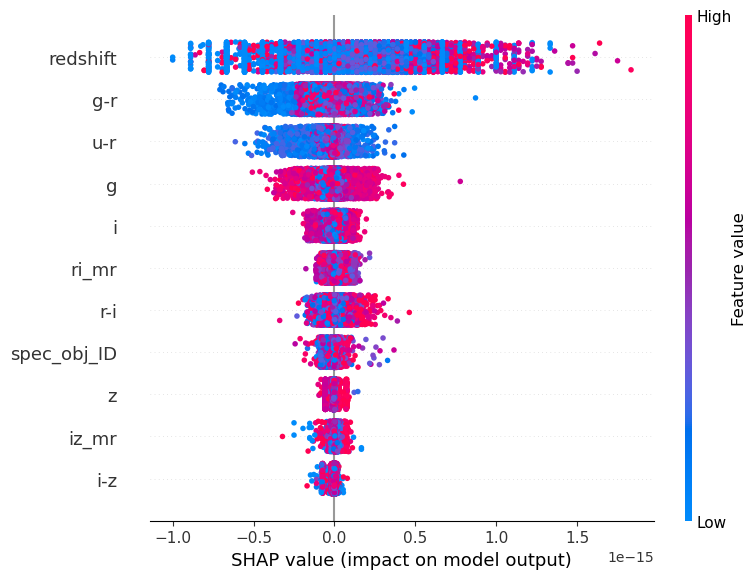

In [65]:
# Sum up the SHAP values for all classes
shap_values_sum = shap_values.sum(axis=2)

# Generowanie wykresu podsumowującego wpływ cech na predykcje modelu
shap.summary_plot(shap_values_sum, X_test)

In [66]:
# Generate force plot for the first observation and the first class ('GALAXY')
print("GALAXY")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,0], X_test.iloc[0,:], feature_names=X.columns)

GALAXY


In [67]:
# Generate force plot for the first observation and the first class ('QSO')
print("QSO")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,1], X_test.iloc[0,:], feature_names=X.columns)

QSO


In [68]:
# Generate force plot for the first observation and the first class ('STAR')
print("STAR")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,2], X_test.iloc[0,:], feature_names=X.columns)

STAR


### 4.6. Ada boost classifier

Best hyperparameters:  {'n_estimators': 500, 'learning_rate': 0.01}
---------------------------------------------------------------------------------
TRAIN
Accuracy:  0.805265306122449
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


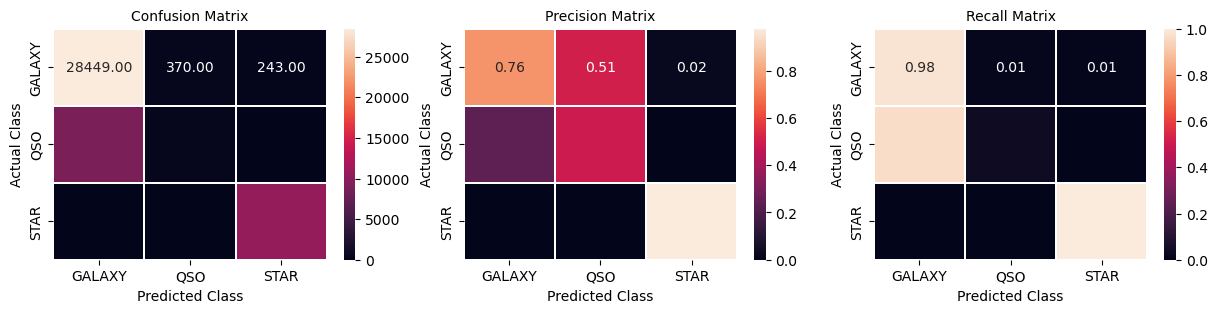

              precision    recall  f1-score   support

      GALAXY       0.76      0.98      0.86     29062
         QSO       0.49      0.04      0.07      9288
        STAR       0.98      1.00      0.99     10650

    accuracy                           0.81     49000
   macro avg       0.74      0.67      0.64     49000
weighted avg       0.76      0.81      0.74     49000

---------------------------------------------------------------------------------
TEST
Accuracy:  0.8068095238095238
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


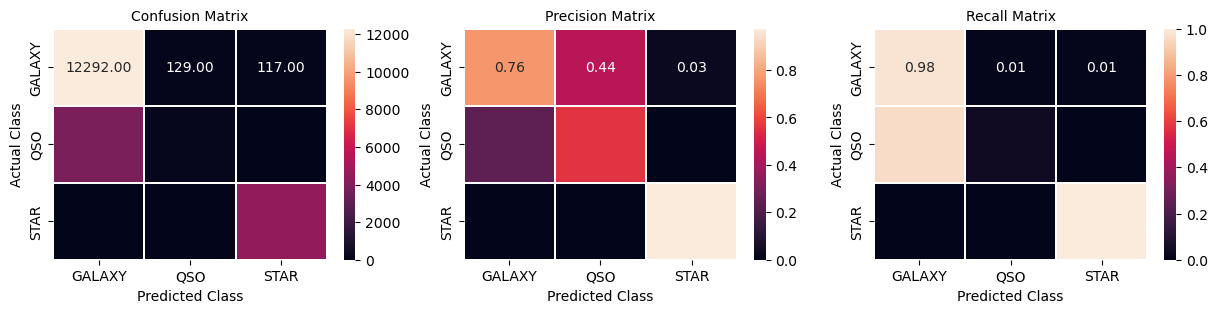

              precision    recall  f1-score   support

      GALAXY       0.76      0.98      0.86     12538
         QSO       0.56      0.04      0.08      3973
        STAR       0.97      1.00      0.99      4489

    accuracy                           0.81     21000
   macro avg       0.76      0.67      0.64     21000
weighted avg       0.77      0.81      0.74     21000

---------------------------------------------------------------------------------
Cross-validation scores:  [0.81438776 0.81102041 0.80091837 0.8072449  0.80663265]
Mean CV score:  0.8080408163265306
---------------------------------------------------------------------------------
Cross-validation scores for test data:  [0.78404762 0.80214286 0.80571429 0.80214286 0.76952381]
Mean CV score for test data:  0.7927142857142856
---------------------------------------------------------------------------------
ROC curve and AUC for each class


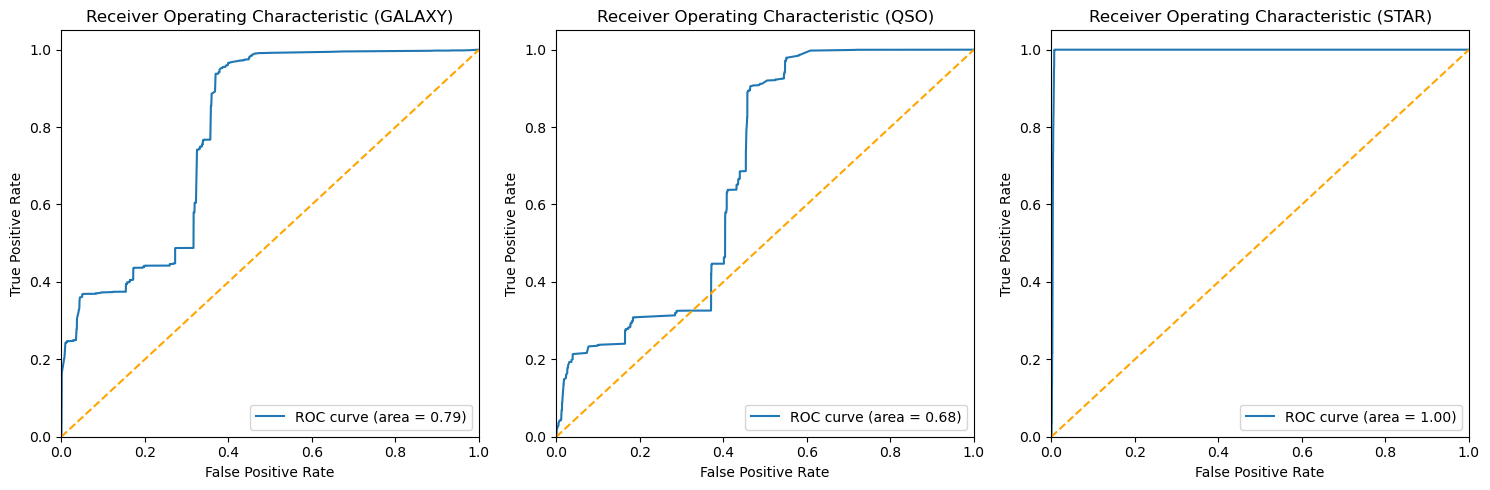

In [15]:
ab = AdaBoostClassifier()
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
ab_best_params, ab_train_accuracy, ab_test_accuracy, ab_cv_scores, ab_cv_test_scores = train_and_evaluate_model(ab, param_grid=grid, X_train=X, y_train=y, X_test=X_test, y_test=y_test)

### SHAP

In [16]:
# Generate background samples based on training data
background = shap.kmeans(X, 1)

# Create the KernelExplainer
explainer = shap.KernelExplainer(ab.predict_proba, background)

# Calculate shap_values
shap_values = explainer.shap_values(X_test)

  0%|          | 0/21000 [00:00<?, ?it/s]

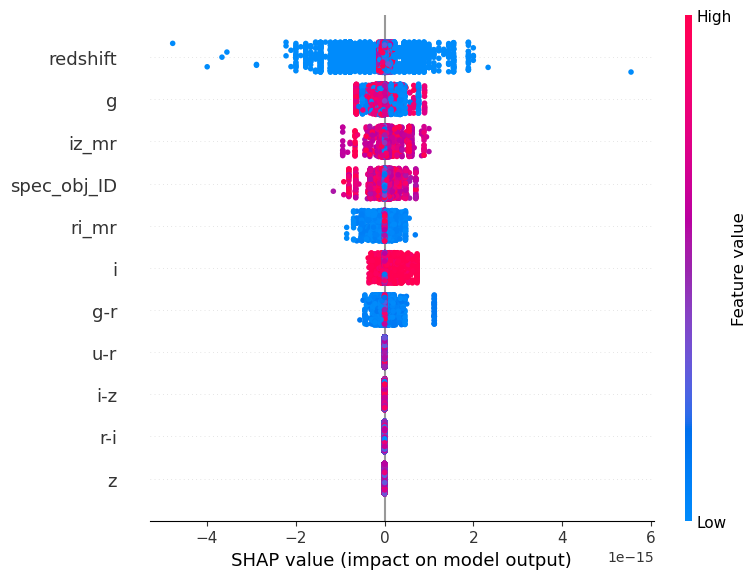

In [17]:
# Sum up the SHAP values for all classes
shap_values_sum = shap_values.sum(axis=2)

# Generowanie wykresu podsumowującego wpływ cech na predykcje modelu
shap.summary_plot(shap_values_sum, X_test)

In [20]:
# Generate force plot for the first observation and the first class ('GALAXY')
print("GALAXY")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,0], X_test.iloc[0,:], feature_names=X.columns)

GALAXY


In [21]:
# Generate force plot for the first observation and the first class ('QSO')
print("QSO")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,1], X_test.iloc[0,:], feature_names=X.columns)

QSO


In [22]:
# Generate force plot for the first observation and the first class ('STAR')
print("STAR")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,2], X_test.iloc[0,:], feature_names=X.columns)

STAR


### 4.7. SVC

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best hyperparameters:  {'C': 1000}
---------------------------------------------------------------------------------
TRAIN
Accuracy:  0.9735918367346938
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


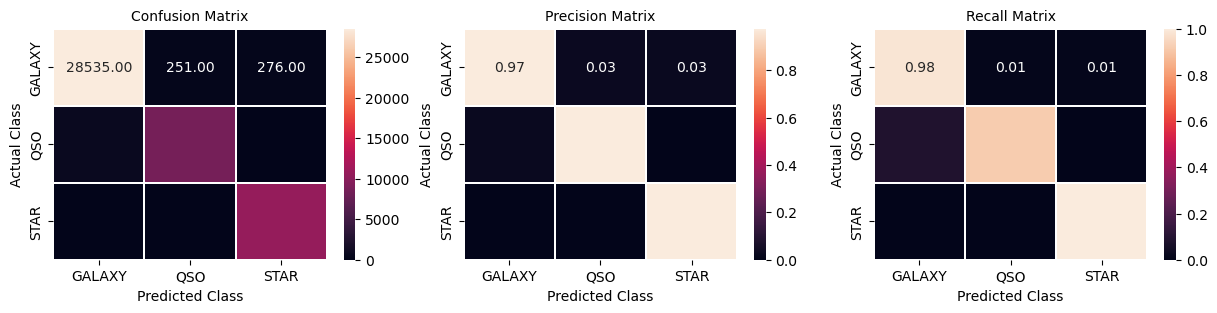

              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.98     29062
         QSO       0.97      0.92      0.94      9288
        STAR       0.97      1.00      0.99     10650

    accuracy                           0.97     49000
   macro avg       0.97      0.97      0.97     49000
weighted avg       0.97      0.97      0.97     49000

---------------------------------------------------------------------------------
TEST
Accuracy:  0.9727619047619047
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


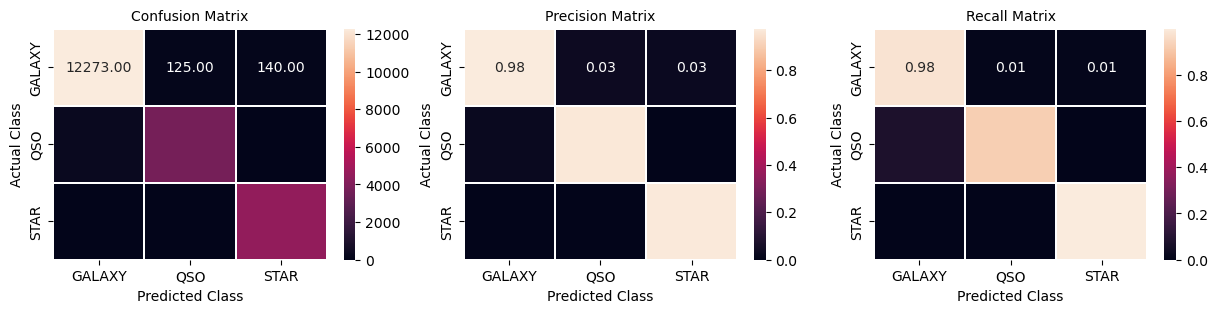

              precision    recall  f1-score   support

      GALAXY       0.98      0.98      0.98     12538
         QSO       0.97      0.92      0.94      3973
        STAR       0.97      1.00      0.98      4489

    accuracy                           0.97     21000
   macro avg       0.97      0.97      0.97     21000
weighted avg       0.97      0.97      0.97     21000

---------------------------------------------------------------------------------
Cross-validation scores:  [0.97153061 0.97122449 0.97285714 0.97214286 0.97193878]
Mean CV score:  0.971938775510204
---------------------------------------------------------------------------------
Cross-validation scores for test data:  [0.97452381 0.96904762 0.97238095 0.9702381  0.97190476]
Mean CV score for test data:  0.9716190476190476
---------------------------------------------------------------------------------
ROC curve and AUC for each class


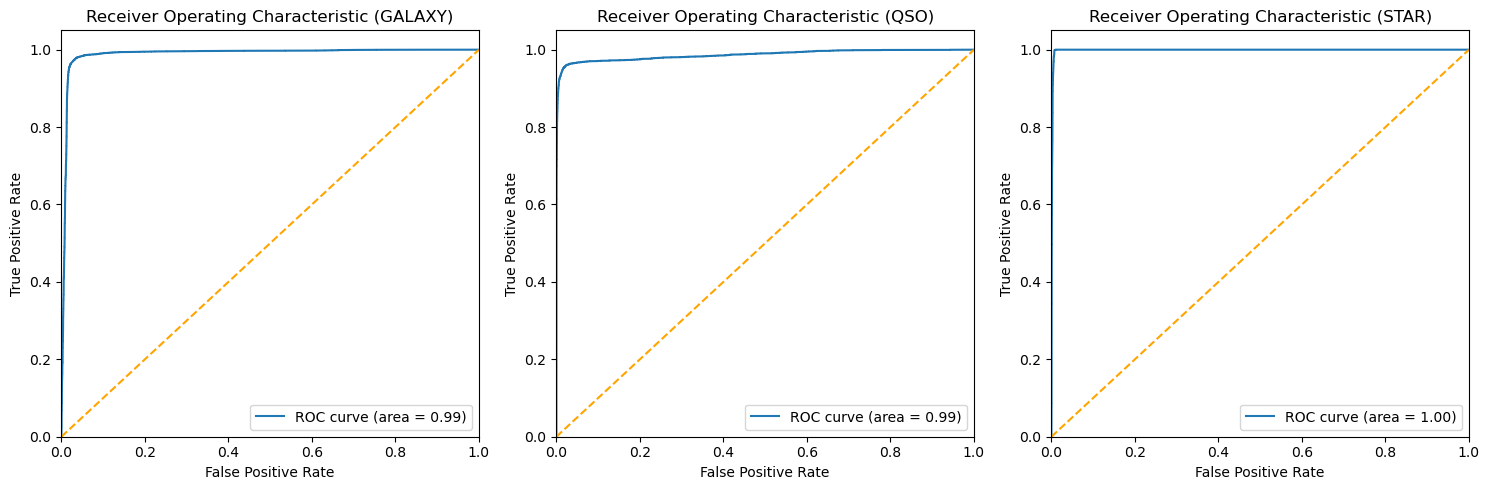

In [85]:
# svc = SVC(probability=True)
# dist = {'C': [0.1, 1, 10, 100, 1000]}
# svc_best_params, svc_train_accuracy, svc_test_accuracy, svc_cv_scores, svc_cv_test_scores = train_and_evaluate_model(svc, param_grid=dist, X_train=X, y_train=y, X_test=X_test, y_test=y_test)

### 4.8. XGBoost

Best hyperparameters:  {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.5}
---------------------------------------------------------------------------------
TRAIN
Accuracy:  0.9978571428571429
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


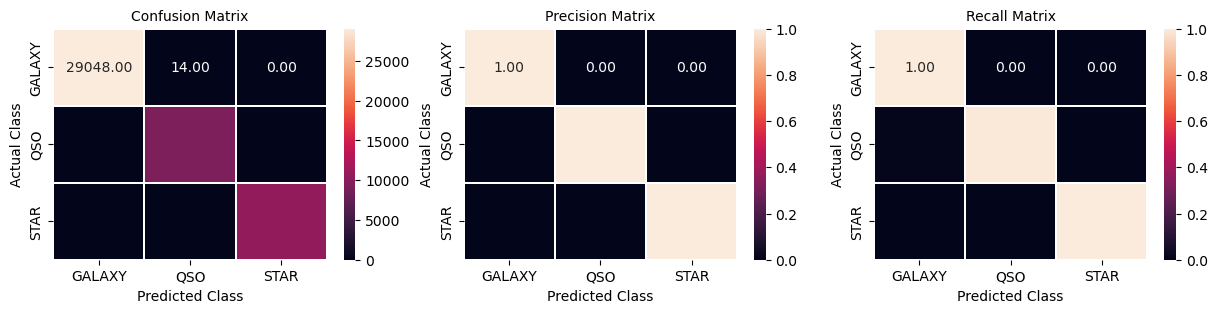

              precision    recall  f1-score   support

      GALAXY       1.00      1.00      1.00     29062
         QSO       1.00      0.99      0.99      9288
        STAR       1.00      1.00      1.00     10650

    accuracy                           1.00     49000
   macro avg       1.00      1.00      1.00     49000
weighted avg       1.00      1.00      1.00     49000

---------------------------------------------------------------------------------
TEST
Accuracy:  0.9792857142857143
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


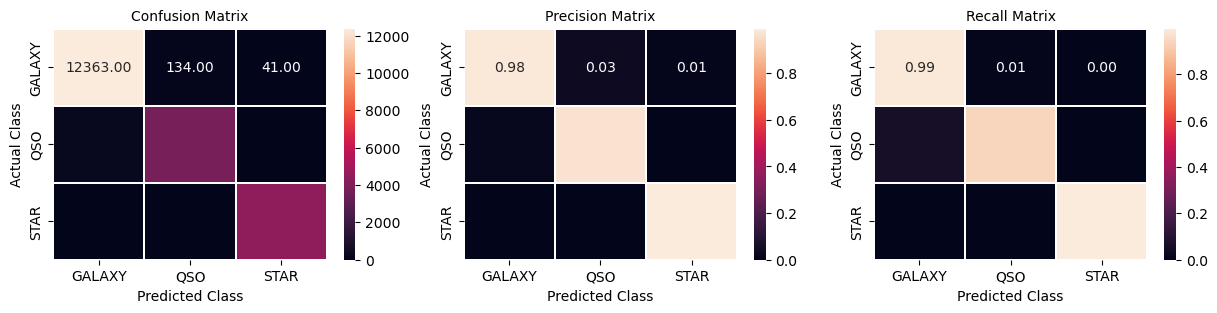

              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98     12538
         QSO       0.97      0.94      0.95      3973
        STAR       0.99      1.00      0.99      4489

    accuracy                           0.98     21000
   macro avg       0.98      0.97      0.98     21000
weighted avg       0.98      0.98      0.98     21000

---------------------------------------------------------------------------------
Cross-validation scores:  [0.97744898 0.97612245 0.97795918 0.97846939 0.97673469]
Mean CV score:  0.9773469387755103
---------------------------------------------------------------------------------
Cross-validation scores for test data:  [0.9797619  0.97404762 0.97952381 0.97714286 0.97761905]
Mean CV score for test data:  0.9776190476190475
---------------------------------------------------------------------------------
ROC curve and AUC for each class


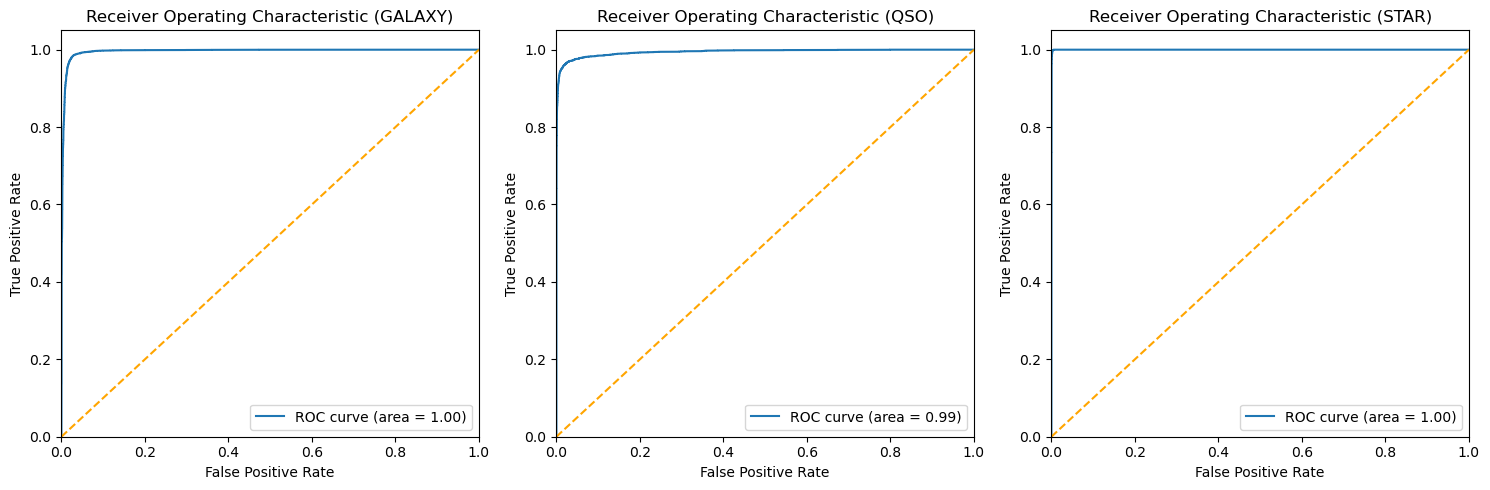

In [23]:
# encoding
label_encoder = LabelEncoder()
y_encoded = y.copy()
y_encoded = label_encoder.fit_transform(y_encoded)
y_test_encoded = y_test.copy()
y_test_encoded = label_encoder.fit_transform(y_test_encoded)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'max_depth': [3, 5, 7],  # Maximum depth of the tree
    'learning_rate': [0.01, 0.1, 0.3],  # Step size shrinkage used in update to prevent overfitting
    'subsample': [0.5, 0.8, 1.0],  # Subsample ratio of the training instance
    'colsample_bytree': [0.5, 0.8, 1.0],  # Subsample ratio of columns when constructing each tree
    'gamma': [0, 0.1, 0.2]  # Minimum loss reduction required to make a further partition on a leaf node of the tree
}

# Create an instance of XGBClassifier
xgb = XGBClassifier(random_state=42)
# Hyperparameter tuning
xgb_best_params, _ = tune_hyperparameters(xgb, param_grid, X, y_encoded)

# Fit the best model to the training data
best_model = xgb.set_params(**xgb_best_params)
best_model.fit(X, y_encoded)

# Predictions
train_preds = best_model.predict(X)
test_preds = best_model.predict(X_test)

# un-encode the predictions
train_preds = label_encoder.inverse_transform(train_preds)
test_preds = label_encoder.inverse_transform(test_preds)

# Calculate accuracy
train_accuracy = accuracy_score(y, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)

# Cross-validation
cv_scores = cross_val_score(best_model, X, y_encoded, cv=5)
cv_test_scores = cross_val_score(best_model, X_test, y_test_encoded, cv=5)

# print best params 
print("Best hyperparameters: ", xgb_best_params)
print("---------------------------------------------------------------------------------")
# Report for train
print("TRAIN")
print("Accuracy: ", train_accuracy)
plot_confusion_matrix(y, train_preds, labels=['GALAXY', 'QSO', 'STAR'])
print(classification_report(y, train_preds, target_names=['GALAXY', 'QSO', 'STAR']))
print("---------------------------------------------------------------------------------")

# Report for test
print("TEST")
print("Accuracy: ", test_accuracy)
plot_confusion_matrix(y_test, test_preds, labels=['GALAXY', 'QSO', 'STAR'])
print(classification_report(y_test, test_preds, target_names=['GALAXY', 'QSO', 'STAR']))
print("---------------------------------------------------------------------------------")

# Cross-validation scores
print("Cross-validation scores: ", cv_scores)
print("Mean CV score: ", np.mean(cv_scores))    
print("---------------------------------------------------------------------------------")
print("Cross-validation scores for test data: ", cv_test_scores)
print("Mean CV score for test data: ", np.mean(cv_test_scores))

# Plot ROC curve for each class and calculate AUC
print("---------------------------------------------------------------------------------")
print("ROC curve and AUC for each class")
_, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axs):
    y_true_binary = (y_test == label_encoder.classes_[i]).astype(int)
    y_prob = best_model.predict_proba(X_test)[:, i]  # predict_proba
    plot_roc_curve(y_true_binary, y_prob, class_label=label_encoder.classes_[i], ax=ax)
    
plt.tight_layout()
plt.show()

# svc_best_params, svc_train_accuracy, svc_test_accuracy, svc_cv_scores, svc_cv_test_scores
xgb_train_accuracy = train_accuracy
xgb_test_accuracy = test_accuracy
xgb_cv_scores = cv_scores
xgb_cv_test_scores = cv_test_scores

In [27]:
# Create a TreeExplainer object
explainer = shap.TreeExplainer(best_model)

# Calculate shap_values for all of X
shap_values = explainer.shap_values(X_test)

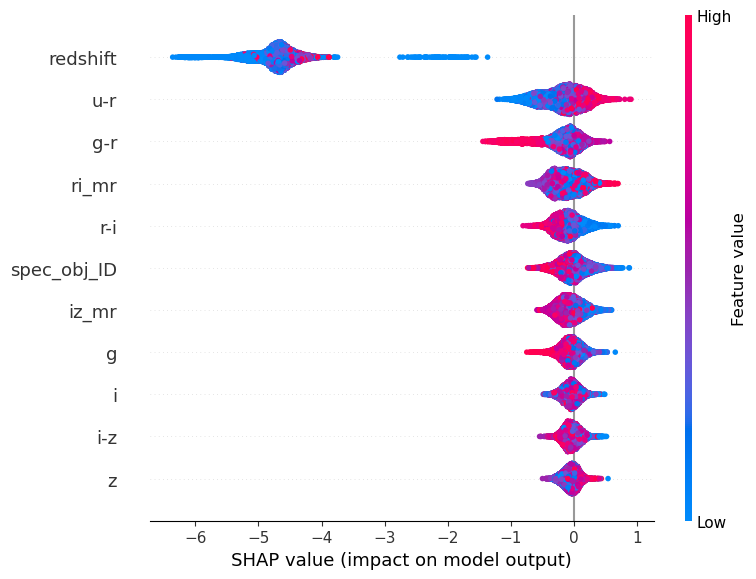

In [28]:
# Sum up the SHAP values for all classes
shap_values_sum = shap_values.sum(axis=2)

# Generate summary plot
shap.summary_plot(shap_values_sum, X_test)

In [29]:
# Generate force plot for the first observation and the first class ('GALAXY')
print("GALAXY")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,0], X_test.iloc[0,:], feature_names=X.columns)

GALAXY


In [30]:
# Generate force plot for the first observation and the first class ('QSO')
print("QSO")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,1], X_test.iloc[0,:], feature_names=X.columns)

QSO


In [31]:
# Generate force plot for the first observation and the first class ('STAR')
print("STAR")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,2], X_test.iloc[0,:], feature_names=X.columns)

STAR


### 4.9. Stacking classifier


TRAIN
Accuracy:  0.9819183673469388
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


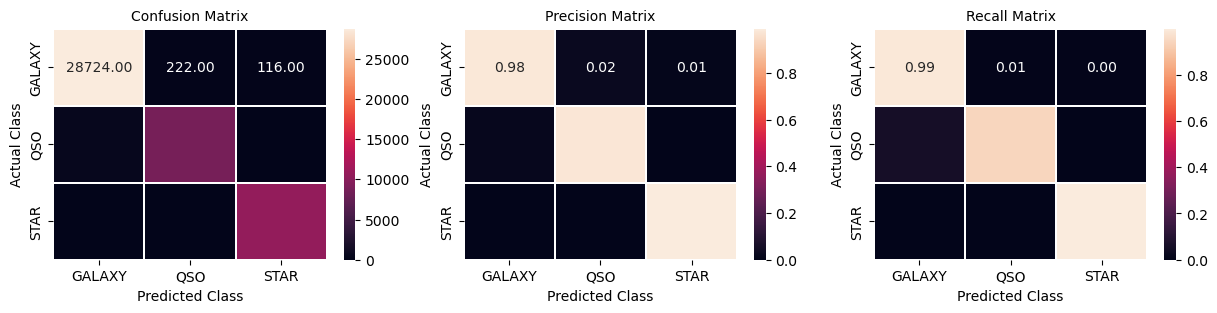

              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98     29062
         QSO       0.98      0.94      0.96      9288
        STAR       0.99      1.00      0.99     10650

    accuracy                           0.98     49000
   macro avg       0.98      0.98      0.98     49000
weighted avg       0.98      0.98      0.98     49000

---------------------------------------------------------------------------------
TEST
Accuracy:  0.9763333333333334
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


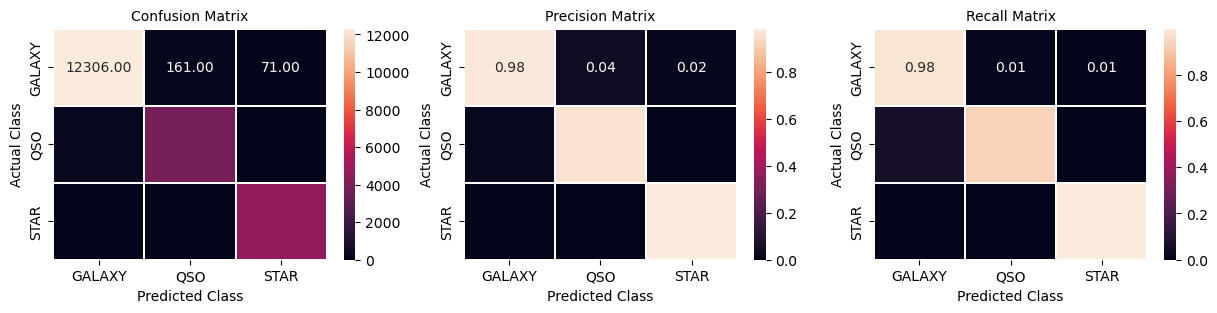

              precision    recall  f1-score   support

      GALAXY       0.98      0.98      0.98     12538
         QSO       0.96      0.94      0.95      3973
        STAR       0.98      1.00      0.99      4489

    accuracy                           0.98     21000
   macro avg       0.97      0.97      0.97     21000
weighted avg       0.98      0.98      0.98     21000

---------------------------------------------------------------------------------
Cross-validation scores:  [0.97459184 0.97459184 0.97734694 0.97428571 0.97693878]
Mean CV score:  0.9755510204081632
---------------------------------------------------------------------------------
Cross-validation scores for test data:  [0.97857143 0.97380952 0.97285714 0.97452381 0.97238095]
Mean CV score for test data:  0.9744285714285713
---------------------------------------------------------------------------------
ROC curve and AUC for each class


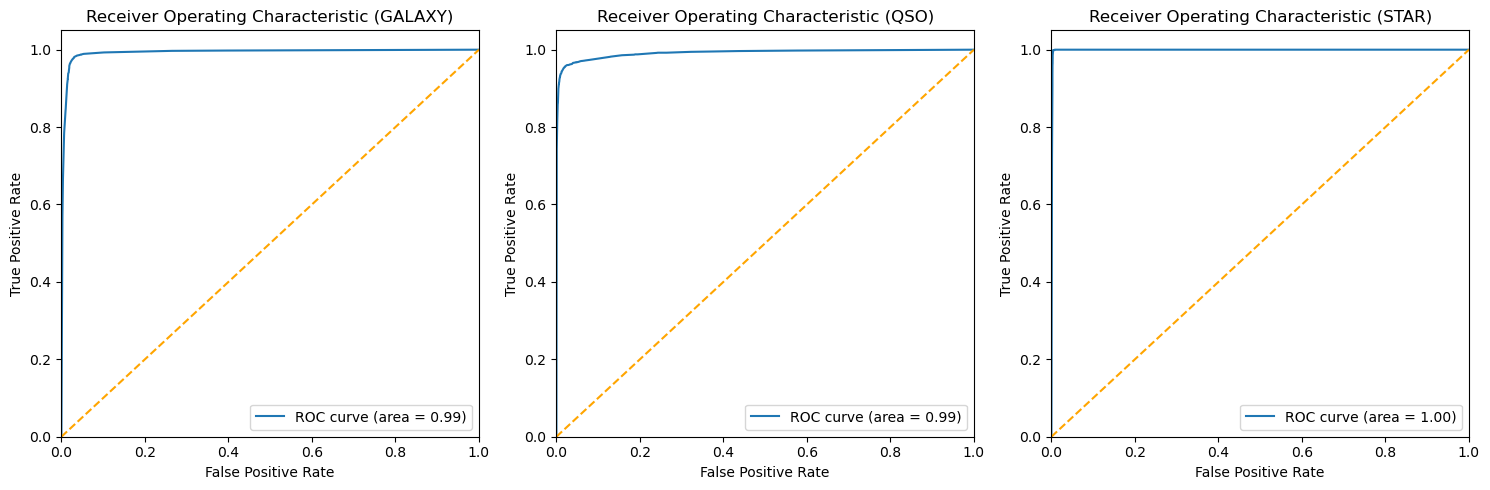

In [89]:
# # Define your models
# LR = LogisticRegression(penalty=lg_best_params['penalty'],
#                         C=lg_best_params['C'],
#                         class_weight='balanced',
#                         random_state=42,
#                         n_jobs=-1, max_iter=1000)

# SV = SVC(C=svc_best_params['C'], random_state=42, class_weight='balanced')

# KNN = KNeighborsClassifier(n_neighbors=knn_best_params['n_neighbors'], n_jobs=-1)

# DT = DecisionTreeClassifier(criterion=dt_best_params['criterion'],
#                             max_depth=dt_best_params['max_depth'],
#                             min_samples_split=dt_best_params['min_samples_split'],
#                             random_state=42)

# models = [('LR', LR), ('SVC', SV), ('KNN', KNN), ('DT', DT)]

# # Create StackingClassifier
# stack = StackingClassifier(estimators=models, final_estimator=RandomForestClassifier(random_state=42))

# # Fit StackingClassifier
# stack.fit(X, y)

# # Predictions
# train_preds = stack.predict(X)
# test_preds = stack.predict(X_test)

# # Calculate accuracy
# stack_train_accuracy = accuracy_score(y, train_preds)
# stack_test_accuracy = accuracy_score(y_test, test_preds)

# # Cross-validation
# stack_cv_scores = cross_val_score(stack, X, y, cv=5)
# stack_cv_test_scores = cross_val_score(stack, X_test, y_test, cv=5)

# # Print results
# print("TRAIN")
# print("Accuracy: ", stack_train_accuracy)
# plot_confusion_matrix(y, train_preds, labels=['GALAXY', 'QSO', 'STAR'])
# print(classification_report(y, train_preds, target_names=['GALAXY', 'QSO', 'STAR']))
# print("---------------------------------------------------------------------------------")

# print("TEST")
# print("Accuracy: ", stack_test_accuracy)
# plot_confusion_matrix(y_test, test_preds, labels=['GALAXY', 'QSO', 'STAR'])
# print(classification_report(y_test, test_preds, target_names=['GALAXY', 'QSO', 'STAR']))
# print("---------------------------------------------------------------------------------")

# print("Cross-validation scores: ", stack_cv_scores)
# print("Mean CV score: ", np.mean(stack_cv_scores))
# print("---------------------------------------------------------------------------------")
# print("Cross-validation scores for test data: ", stack_cv_test_scores)
# print("Mean CV score for test data: ", np.mean(stack_cv_test_scores))

# # Plot ROC curve for each class and calculate AUC
# print("---------------------------------------------------------------------------------")
# print("ROC curve and AUC for each class")
# _, axs = plt.subplots(1, 3, figsize=(15, 5))
# for i, ax in enumerate(axs):
#     y_true_binary = (y_test == label_encoder.classes_[i]).astype(int)
#     y_prob = stack.predict_proba(X_test)[:, i]  # predict_proba
#     plot_roc_curve(y_true_binary, y_prob, class_label=label_encoder.classes_[i], ax=ax)
    
# plt.tight_layout()
# plt.show()

## 5. Wybrany model
Podsumujmy proces modelowania i wybierzmy najlepszy model dla naszego problemu.

+---+---------------------+----------------+---------------+---------------+-----------------------------+
|   |        Model        | Train Accuracy | Test Accuracy | CV Mean Score | CV Mean Score for Test Data |
+---+---------------------+----------------+---------------+---------------+-----------------------------+
| 7 |       XGBoost       |     0.9979     |    0.9793     |    0.9773     |           0.9776            |
| 1 |    Random Forest    |     0.9988     |    0.9788     |    0.9781     |           0.9772            |
| 8 |      Stacking       |     0.9819     |    0.9763     |    0.9756     |           0.9744            |
| 6 |         SVC         |     0.9736     |    0.9728     |    0.9719     |           0.9716            |
| 4 |    Decision Tree    |     0.9827     |    0.9724     |    0.9726     |            0.968            |
| 3 | K-Nearest Neighbors |     0.9652     |     0.955     |    0.9538     |            0.945            |
| 0 | Logistic Regression |     0.956

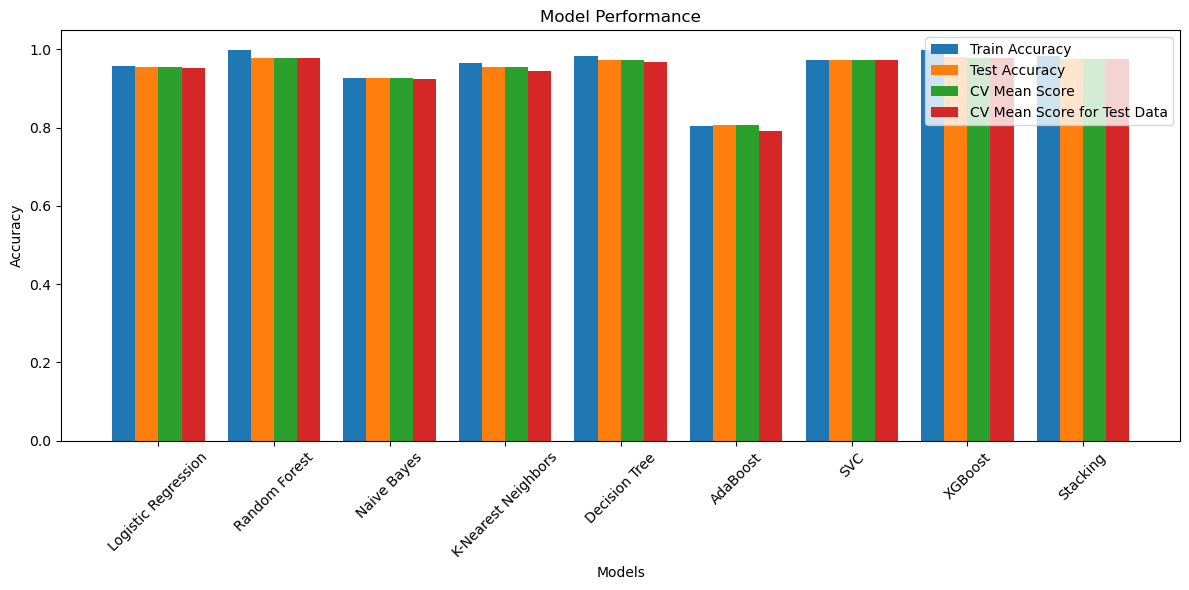

In [90]:
model_names = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'K-Nearest Neighbors', 'Decision Tree', 'AdaBoost', 'SVC', 'XGBoost', 'Stacking']


train_accuracy = [lg_train_accuracy, rf_train_accuracy, nb_train_accuracy, knn_train_accuracy, dt_train_accuracy, ab_train_accuracy, svc_train_accuracy, xgb_train_accuracy, stack_train_accuracy]
test_accuracy = [lg_test_accuracy, rf_test_accuracy, nb_test_accuracy, knn_test_accuracy, dt_test_accuracy, ab_test_accuracy, svc_test_accuracy, xgb_test_accuracy, stack_test_accuracy]
# average of cv scores
cv_scores = [np.mean(lg_cv_scores), np.mean(rf_cv_scores), np.mean(nb_cv_scores), np.mean(knn_cv_scores), np.mean(dt_cv_scores), np.mean(ab_cv_scores), np.mean(svc_cv_scores), np.mean(xgb_cv_scores), np.mean(stack_cv_scores)]
cv_test_scores = [np.mean(lg_cv_test_scores), np.mean(rf_cv_test_scores), np.mean(nb_cv_test_scores), np.mean(knn_cv_test_scores), np.mean(dt_cv_test_scores), np.mean(ab_cv_test_scores), np.mean(svc_cv_test_scores), np.mean(xgb_cv_test_scores), np.mean(stack_cv_test_scores)]

results = pd.DataFrame({'Model': model_names, 'Train Accuracy': train_accuracy, 'Test Accuracy': test_accuracy, 'CV Mean Score': cv_scores, 'CV Mean Score for Test Data': cv_test_scores})

# round all accuracies to 4 decimal places
results = results.round(4)

# results order by test accuracy
results = results.sort_values(by='Test Accuracy', ascending=False)
results = tabulate(results, headers='keys', tablefmt='pretty', showindex=True)
print(results)
# visualize
plt.figure(figsize=(12, 6))

# Set the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
index = np.arange(len(model_names))

# Plot bars for train accuracy
plt.bar(index - 1.5*bar_width, train_accuracy, bar_width, label='Train Accuracy')
# Plot bars for test accuracy
plt.bar(index - 0.5*bar_width, test_accuracy, bar_width, label='Test Accuracy')
# Plot bars for CV mean score
plt.bar(index + 0.5*bar_width, cv_scores, bar_width, label='CV Mean Score')
# Plot bars for CV mean score for test data
plt.bar(index + 1.5*bar_width, cv_test_scores, bar_width, label='CV Mean Score for Test Data')

# Add x-axis labels
plt.xlabel('Models')
# Add y-axis label
plt.ylabel('Accuracy')
# Add title
plt.title('Model Performance')
# Add x-axis ticks and rotate labels for better readability
plt.xticks(index, model_names, rotation=45)
# Add legend
plt.legend()
# Show plot
plt.tight_layout()
plt.show()


Wnioski:
